<center><h1>  Financial Analytics / Finansal Analitik </h1>
<h2>  Corporate Bankruptcy Prediction / Kurumsal İflas Tahmini


--------------

## Table of Contents
## İçindekiler

1. Import Packages
2. Load and Explore the Dataset
3. Preliminary Data Cleaning
4. Data Pre-processing
5. Logistic Regression
6. Random Forest
7. Naive Bayes 
8. Voting Classifier
9. Model Selection
------------------------------------
1. Paketleri İçe Aktar
2. Veri Kümesini Yükleyin ve Keşfedin
3. Ön Veri Temizleme
4. Veri Ön İşleme
5. Lojistik Regresyon
6. Rastgele Orman
7. Naif Bayes
8. Oylama Sınıflandırıcısı
9. Model Seçimi

--------------

## 1) Import Packages

### 1.1) Standard Libaries
### 1.1) Standart Kitaplıklar

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


# Set Options for display
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 2)


%matplotlib inline

### 1.2) Additional Libraries for Modelling
### 1.2) Modelleme için Ek Kitaplıklar

In [2]:
from sklearn.impute import KNNImputer

In [3]:
from scipy.stats.mstats import winsorize

In [4]:
from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import (
    SMOTE,
    BorderlineSMOTE,
    SVMSMOTE,
)

from imblearn.combine import SMOTEENN, SMOTETomek

In [5]:
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler
)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

In [8]:
from sklearn import metrics

In [9]:
from sklearn.model_selection import GridSearchCV

----------

## 2) Load and Explore the Dataset
## 2) Veri Kümesini Yükleyin ve Keşfedin

### 2.1) Load the Dataset
### 2.1) Veri Kümesini Yükleyin

In [10]:
filepath = "bankruptcy_data.xlsx"
df = pd.read_excel(filepath)

In [11]:
df.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.5800,0.3600,0.1800,0.1300,1.3300,1.7700,0.0700,0.1500,2.2200,NaN,NaN,NaN,0
1,1.4100,0.3600,0.1900,0.1200,1.3100,1.5900,0.0700,0.1300,2.4100,0.1263,0.0143,0.0402,0
2,0.3100,0.3200,0.1300,0.0800,1.0300,1.5500,0.0500,0.0400,2.5600,0.3681,0.3279,0.5665,0


In [12]:
df.shape

(92872, 13)

In [13]:
# Create Copy of Original Dataset
# Orijinal Veri Kümesinin Kopyasını Oluştur
df_orig = df.copy()

### 2.2) Explore Data Types
### 2.2) Veri Türlerini Keşfedin

In [14]:
# See Columns and Data Types
# Sütunlara ve Veri Türlerine Bakın
df.info() #all numeric columns / tüm sayısal sütunlar

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EPS                 92867 non-null  float64
 1   Liquidity           92625 non-null  float64
 2   Profitability       92625 non-null  float64
 3   Productivity        92625 non-null  float64
 4   Leverage Ratio      92846 non-null  float64
 5   Asset Turnover      92625 non-null  float64
 6   Operational Margin  87315 non-null  float64
 7   Return on Equity    92864 non-null  float64
 8   Market Book Ratio   92815 non-null  float64
 9   Assets Growth       86171 non-null  float64
 10  Sales Growth        86171 non-null  float64
 11  Employee Growth     85862 non-null  float64
 12  BK                  92872 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 9.2 MB


### 2.3) Explore Statistics and Distribution
### 2.3) İstatistikleri ve Dağıtımı Keşfedin

In [15]:
# Check statistics - to see scale of data
# İstatistikleri kontrol edin - veri ölçeğini görmek için
df_stats = df.describe()
df_stats

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92867.0000,92625.0000,92625.0000,92625.0000,92846.0000,92625.0000,87315.0000,92864.0000,92815.0000,86171.0000,86171.0000,85862.0000,92872.0000
mean,-14.4614,-2.6312,-29.5373,-1.2229,1.3453,1.0536,-7.9155,-2.1124,358.5063,1.2941,1.9001,0.3433,0.0060
std,2195.4673,121.6109,677.2307,35.8856,253.0381,2.1159,214.4601,352.5969,26063.6380,73.7695,177.6326,14.0742,0.0773
min,-384000.0000,-25968.5200,-79682.0000,-5093.0000,-7811.0000,-31.5900,-30175.7000,-88875.1400,-3151500.0000,-1.0000,-27.4310,-1.0000,0.0000
25%,-0.1400,0.0200,-0.6400,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2000,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.2800,0.0518,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,240.1400,0.1921,0.2042,0.1309,0.0000
max,55339.0000,1.0000,140.5800,1102.0000,75970.3800,276.3800,394.4700,39500.0000,3455419.3300,14231.0000,39850.0000,2699.0000,1.0000


### 2.4) Check Target Variable
### 2.4) Hedef Değişkeni Kontrol Edin

In [16]:
#Identify and check the value counts/classes of the target variable
#1 - Bankrupt
#0 - Not Bankrupt

#Hedef değişkenin değer sayılarını/sınıflarını tanımlayın ve kontrol edin
#1 - İflas
#0 - İflas Etmemiş

df["BK"].value_counts() 

0    92314
1      558
Name: BK, dtype: int64

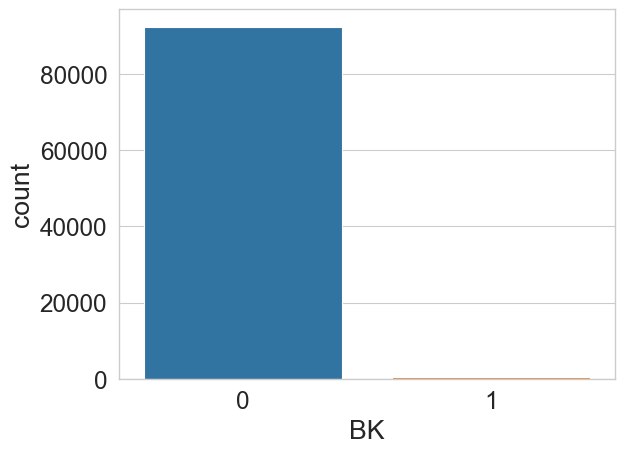

In [17]:
sns.countplot(data = df, x = "BK"); #highly imbalanced

### 2.5) Check Features' Distributions
### 2.5) Özelliklerin Dağıtımlarını Kontrol Edin

In [18]:
# create dataframe of independent variables for data exploration
# veri keşfi için bağımsız değişkenlerin veri çerçevesini oluştur
df_independent = df.drop(["BK"], axis=1)

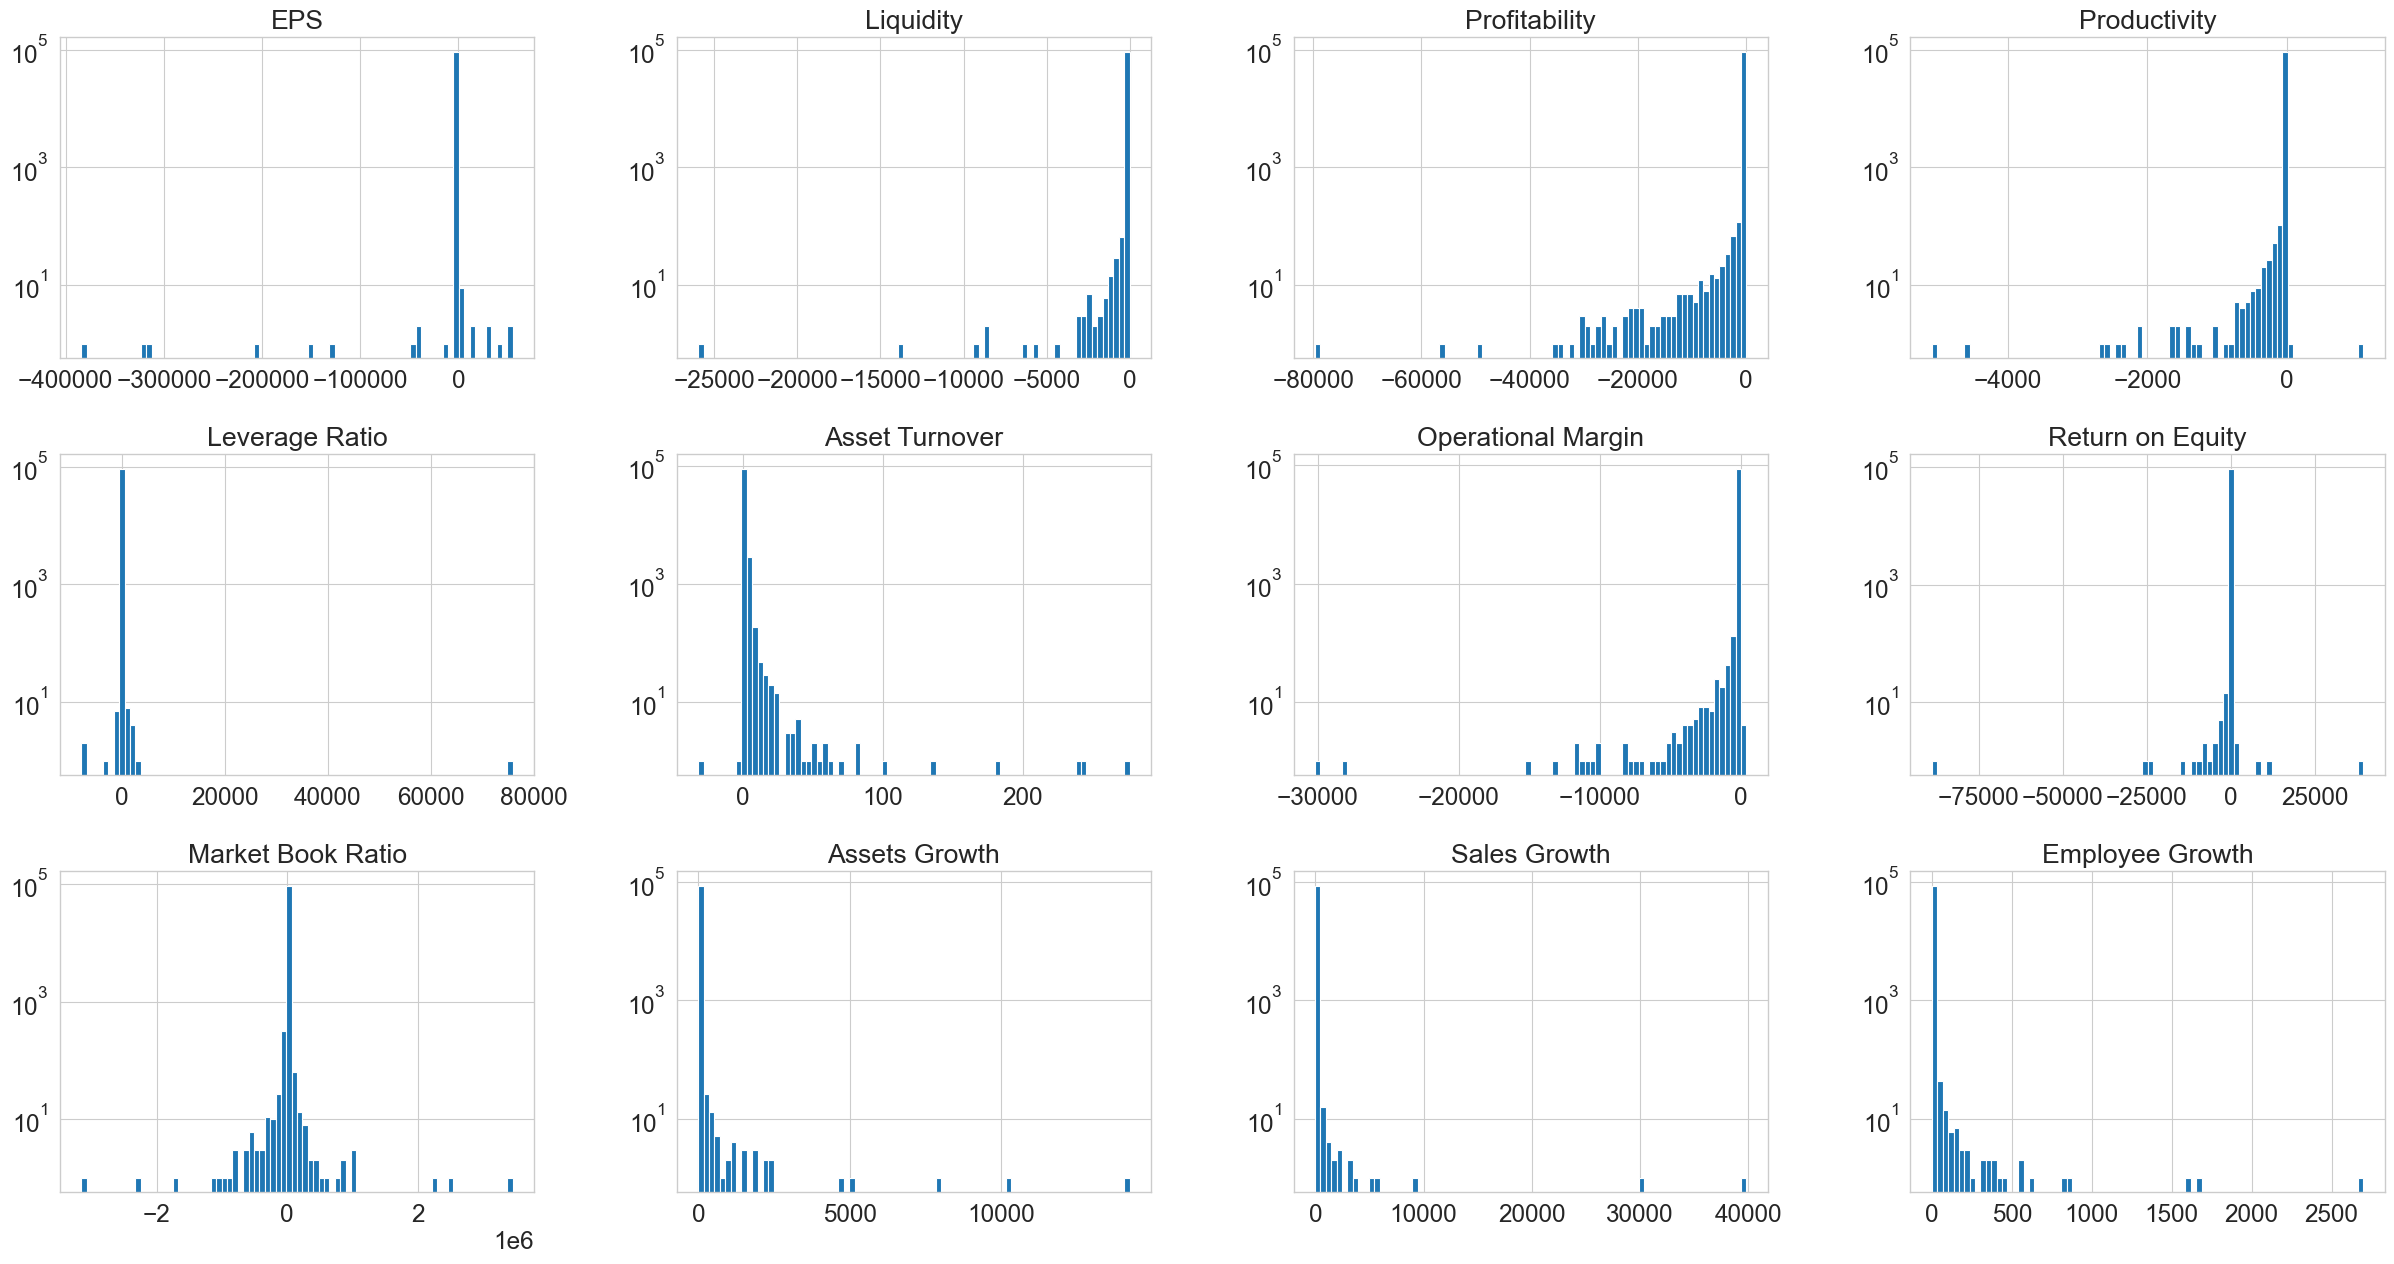

In [19]:
# displaying the distribution of each feature on a logarithmic scale
# her bir özelliğin dağılımını logaritmik ölçekte görüntüleme
df.hist(column = df_independent.columns, bins = 80, figsize = (30,15), layout = (3,4), log = True);

### 2.5) Check Features' Distribution vs. Target
### 2.5) Özelliklerin Hedefe Karşı Dağıtımını Kontrol Edin

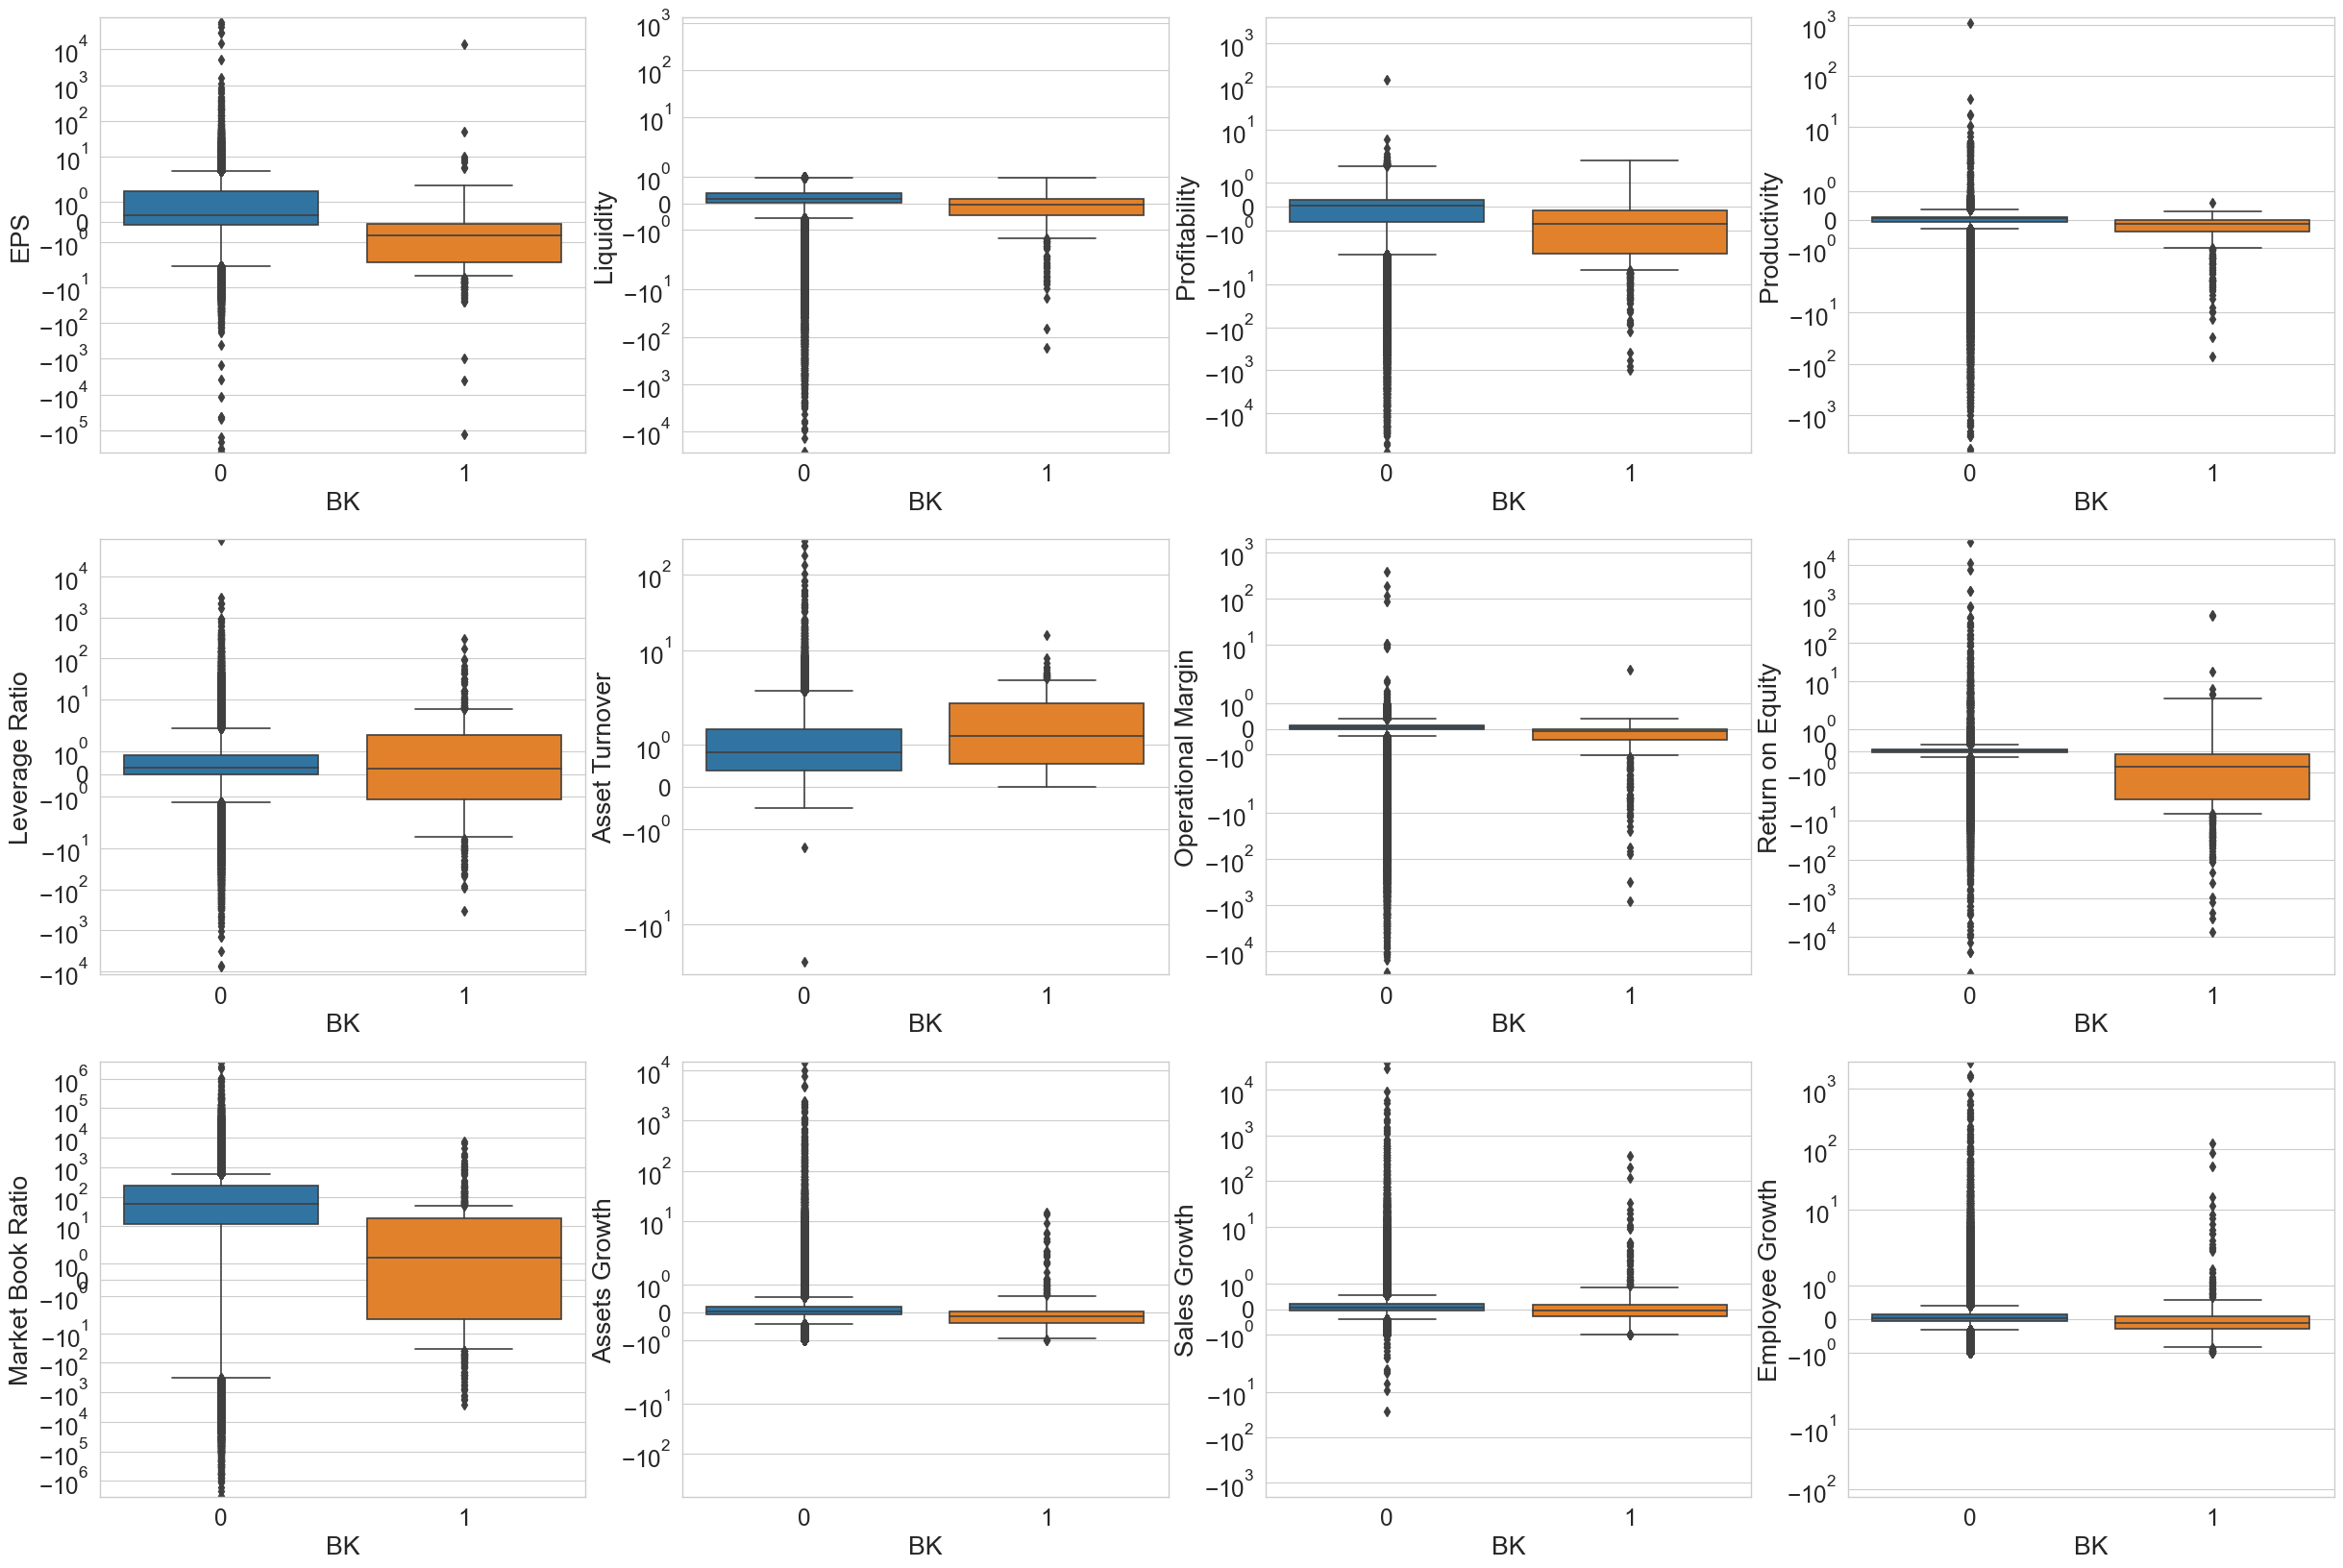

In [20]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,20))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,data=df,x='BK',ax=axes[row,col])
    g.set_yscale('symlog');

<div class="alert alert-info">
<b> Observation: </b> There seems to be several extreme values/ outliers.

<div class="alert alert-info">
<b> Gözlem: </b> Birkaç aşırı değer/ aykırı değer var gibi görünüyor.

### 2.3) Check Correlation of Features
### 2.3) Özelliklerin Korelasyonunu Kontrol Edin

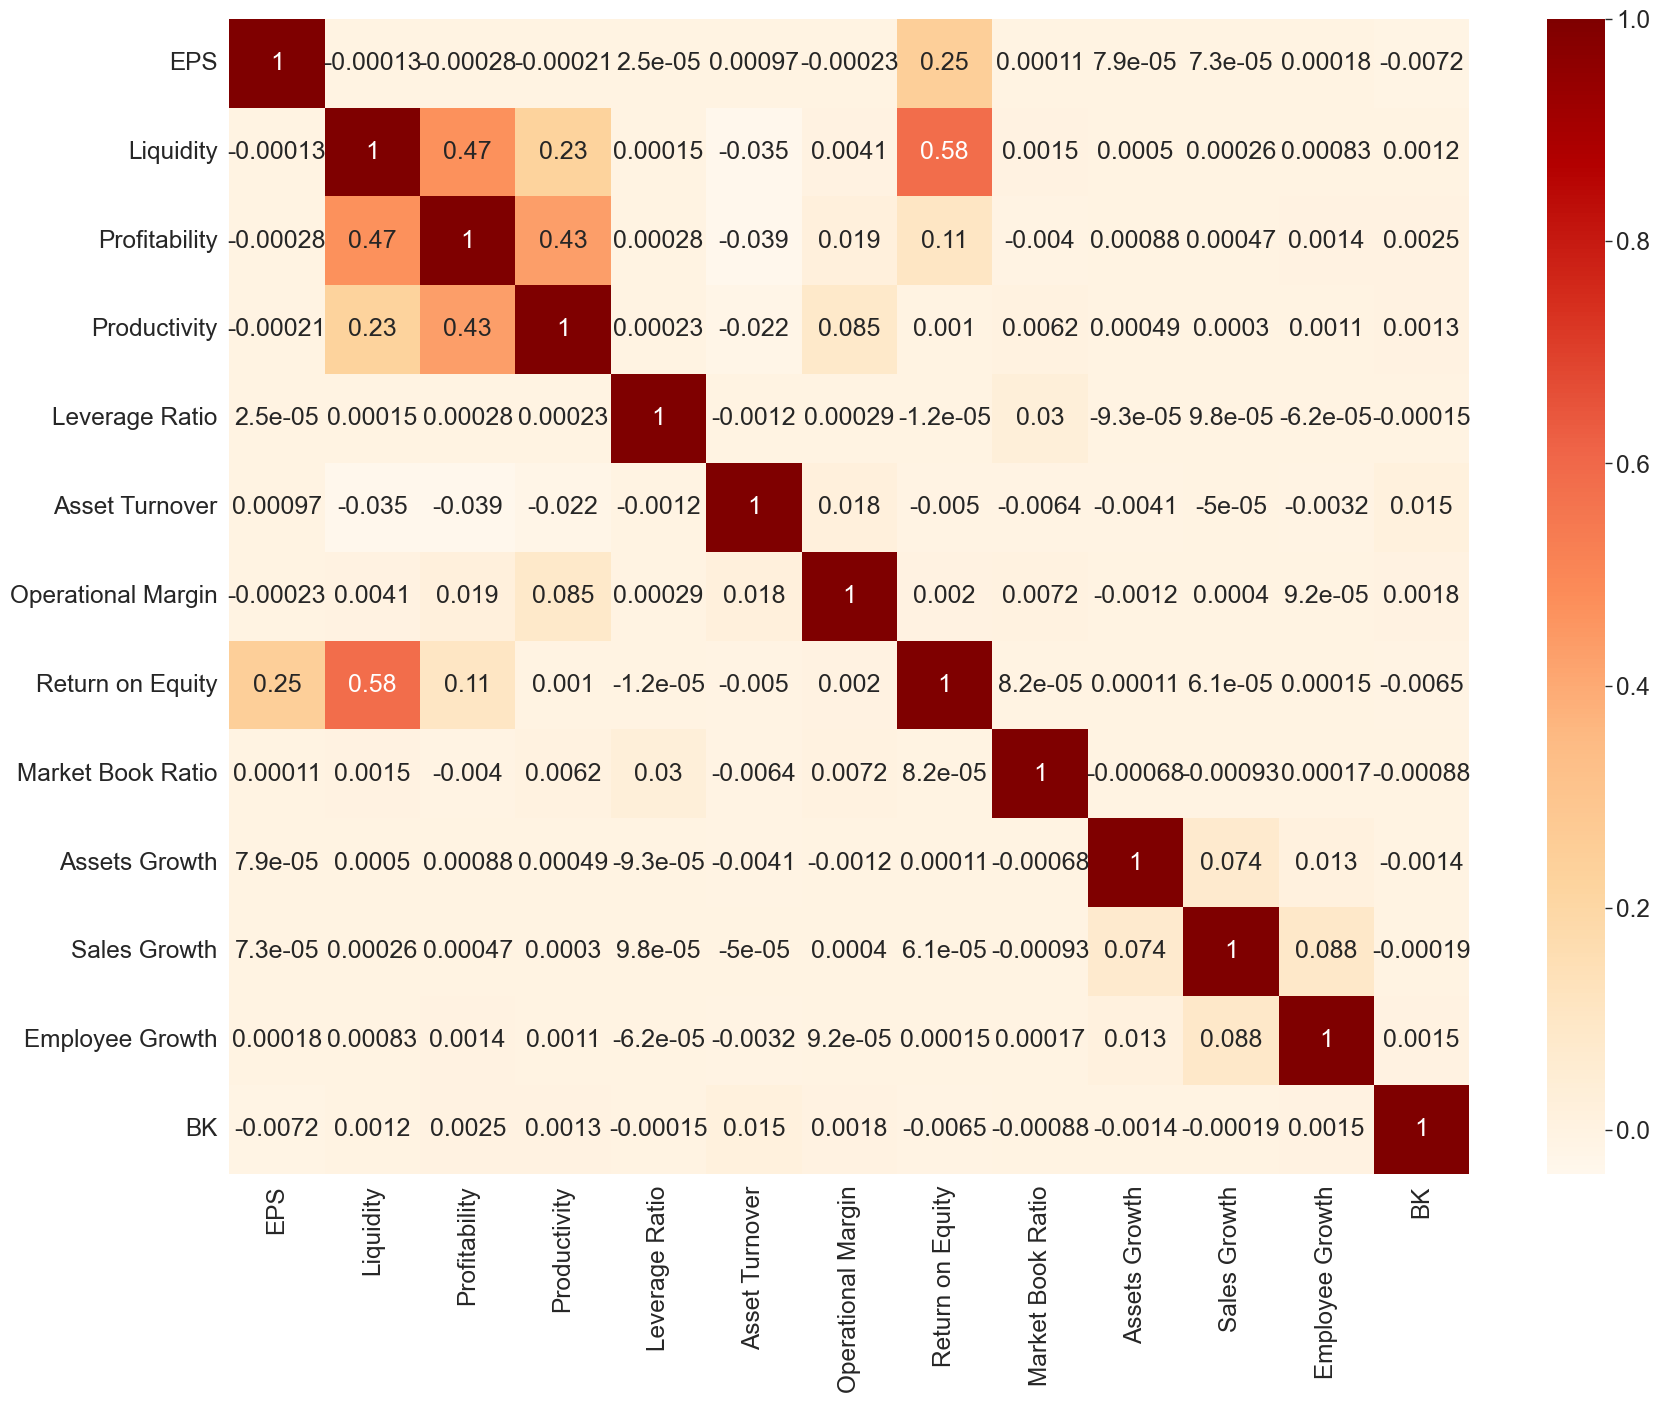

In [21]:
# Create Correlation Heatmap
# Korelasyon Isı Haritası Oluşturun
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot = True, annot_kws={"fontsize":18}, cmap='OrRd');

----------

## 3) Preliminary Data Cleaning
## 3) Ön Veri Temizleme

### 3.1) Check for Duplicates
### 3.1) Kopyaları Kontrol Edin

In [22]:
# Check for duplicates in samples
# Örneklerdeki kopyaları kontrol edin
df.duplicated().value_counts()

False    92845
True        27
dtype: int64

<b> Note: </b> Check with Maverick if duplicates are expected

<b> Not: </b> Yinelemelerin beklenip beklenmediğini Maverick ile kontrol edin

In [23]:
# Drop Duplicates
# Kopyaları Bırak
df.drop_duplicates(inplace=True)

In [24]:
# Recheck Dataframe for duplicates
# Kopyalar için Dataframe'i yeniden kontrol edin
df.duplicated().value_counts()

False    92845
dtype: int64

In [25]:
df["BK"].value_counts() # The bankruptcy cases remain intact / İflas davaları sürüyor

0    92287
1      558
Name: BK, dtype: int64

### 3.2) Checking Outliers
### 3.2) Aykırı Değerleri Kontrol Etme

#### 3.2.1) Checking Effect of Trimming Outliers on the Dataset
#### 3.2.1) Aykırı Değerleri Kırpmanın Veri Kümesi Üzerindeki Etkisini Kontrol Etme

In [26]:
#defining a function to list-wise deletion of records with at least 1 outlier based on a list of columns
#bir sütun listesine dayalı olarak en az 1 aykırı değere sahip kayıtların liste bazında silinmesi için bir işlev tanımlama
def remove_outliers(df,cols,distance = 1.5):
    # Calculate quantiles and IQR
    Q1 = df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100) -- # np.percentile ile aynı, ancak (0,1) eşler ve (0,100) değil
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    # Return a boolean array of the rows with (any) non-outlier column values
    # Aykırı olmayan (herhangi bir) sütun değerine sahip satırların bir boolean dizisini döndürün
    condition = ~((df[cols] < (Q1 - distance * IQR)) | (df[cols] > (Q3 + distance * IQR))).any(axis=1)

    # Filter our dataframe based on condition
    # Veri çerçevemizi koşula göre filtreleyin
    filtered_df = df[condition]
    
    return filtered_df

In [27]:
# Creating a list of indepedent variables
# Bağımsız değişkenler listesi oluşturma
independent_variables = df.columns[:-1].tolist()

In [28]:
# Creating a new dataframe without outliers in any record
# Herhangi bir kayıtta aykırı değerler olmadan yeni bir veri çerçevesi oluşturma
df_noOutliers = remove_outliers(df,independent_variables,3)
df_noOutliers.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1.5800,0.3600,0.1800,0.1300,1.3300,1.7700,0.0700,0.1500,2.2200,NaN,NaN,NaN,0
1,1.4100,0.3600,0.1900,0.1200,1.3100,1.5900,0.0700,0.1300,2.4100,0.1263,0.0143,0.0402,0
2,0.3100,0.3200,0.1300,0.0800,1.0300,1.5500,0.0500,0.0400,2.5600,0.3681,0.3279,0.5665,0


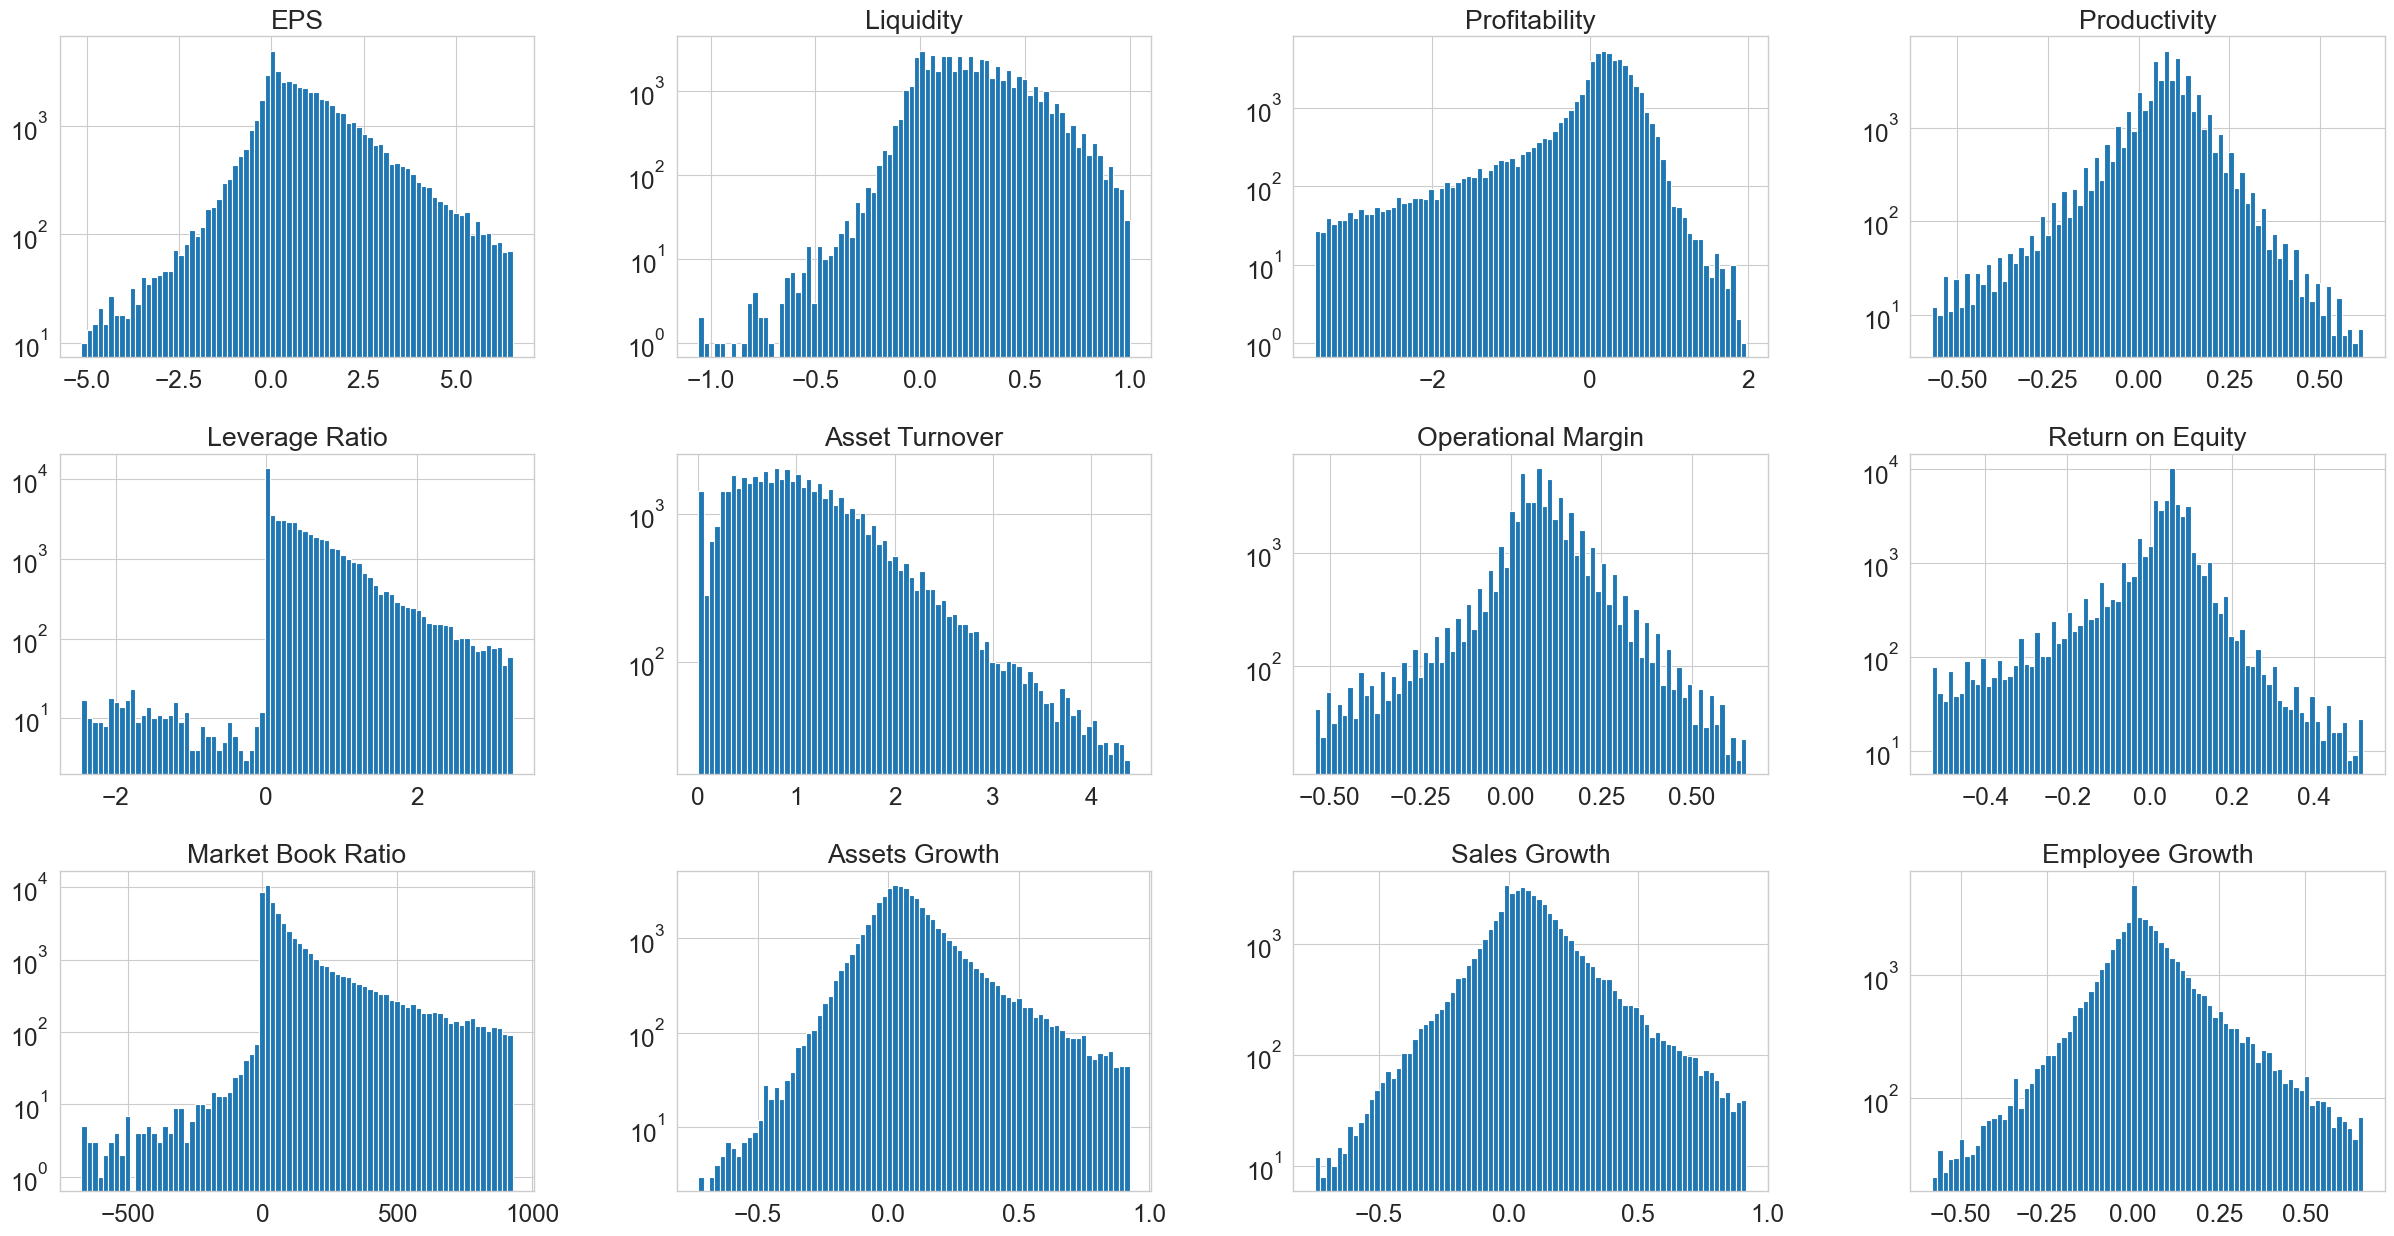

In [29]:
# displaying the distribution of each feature on a logarithmic scale
# her özelliğin dağılımını logaritmik ölçekte görüntüleme
df_noOutliers.hist(column = df_independent.columns, bins = 80, figsize = (30,15), layout = (3,4), log = True);

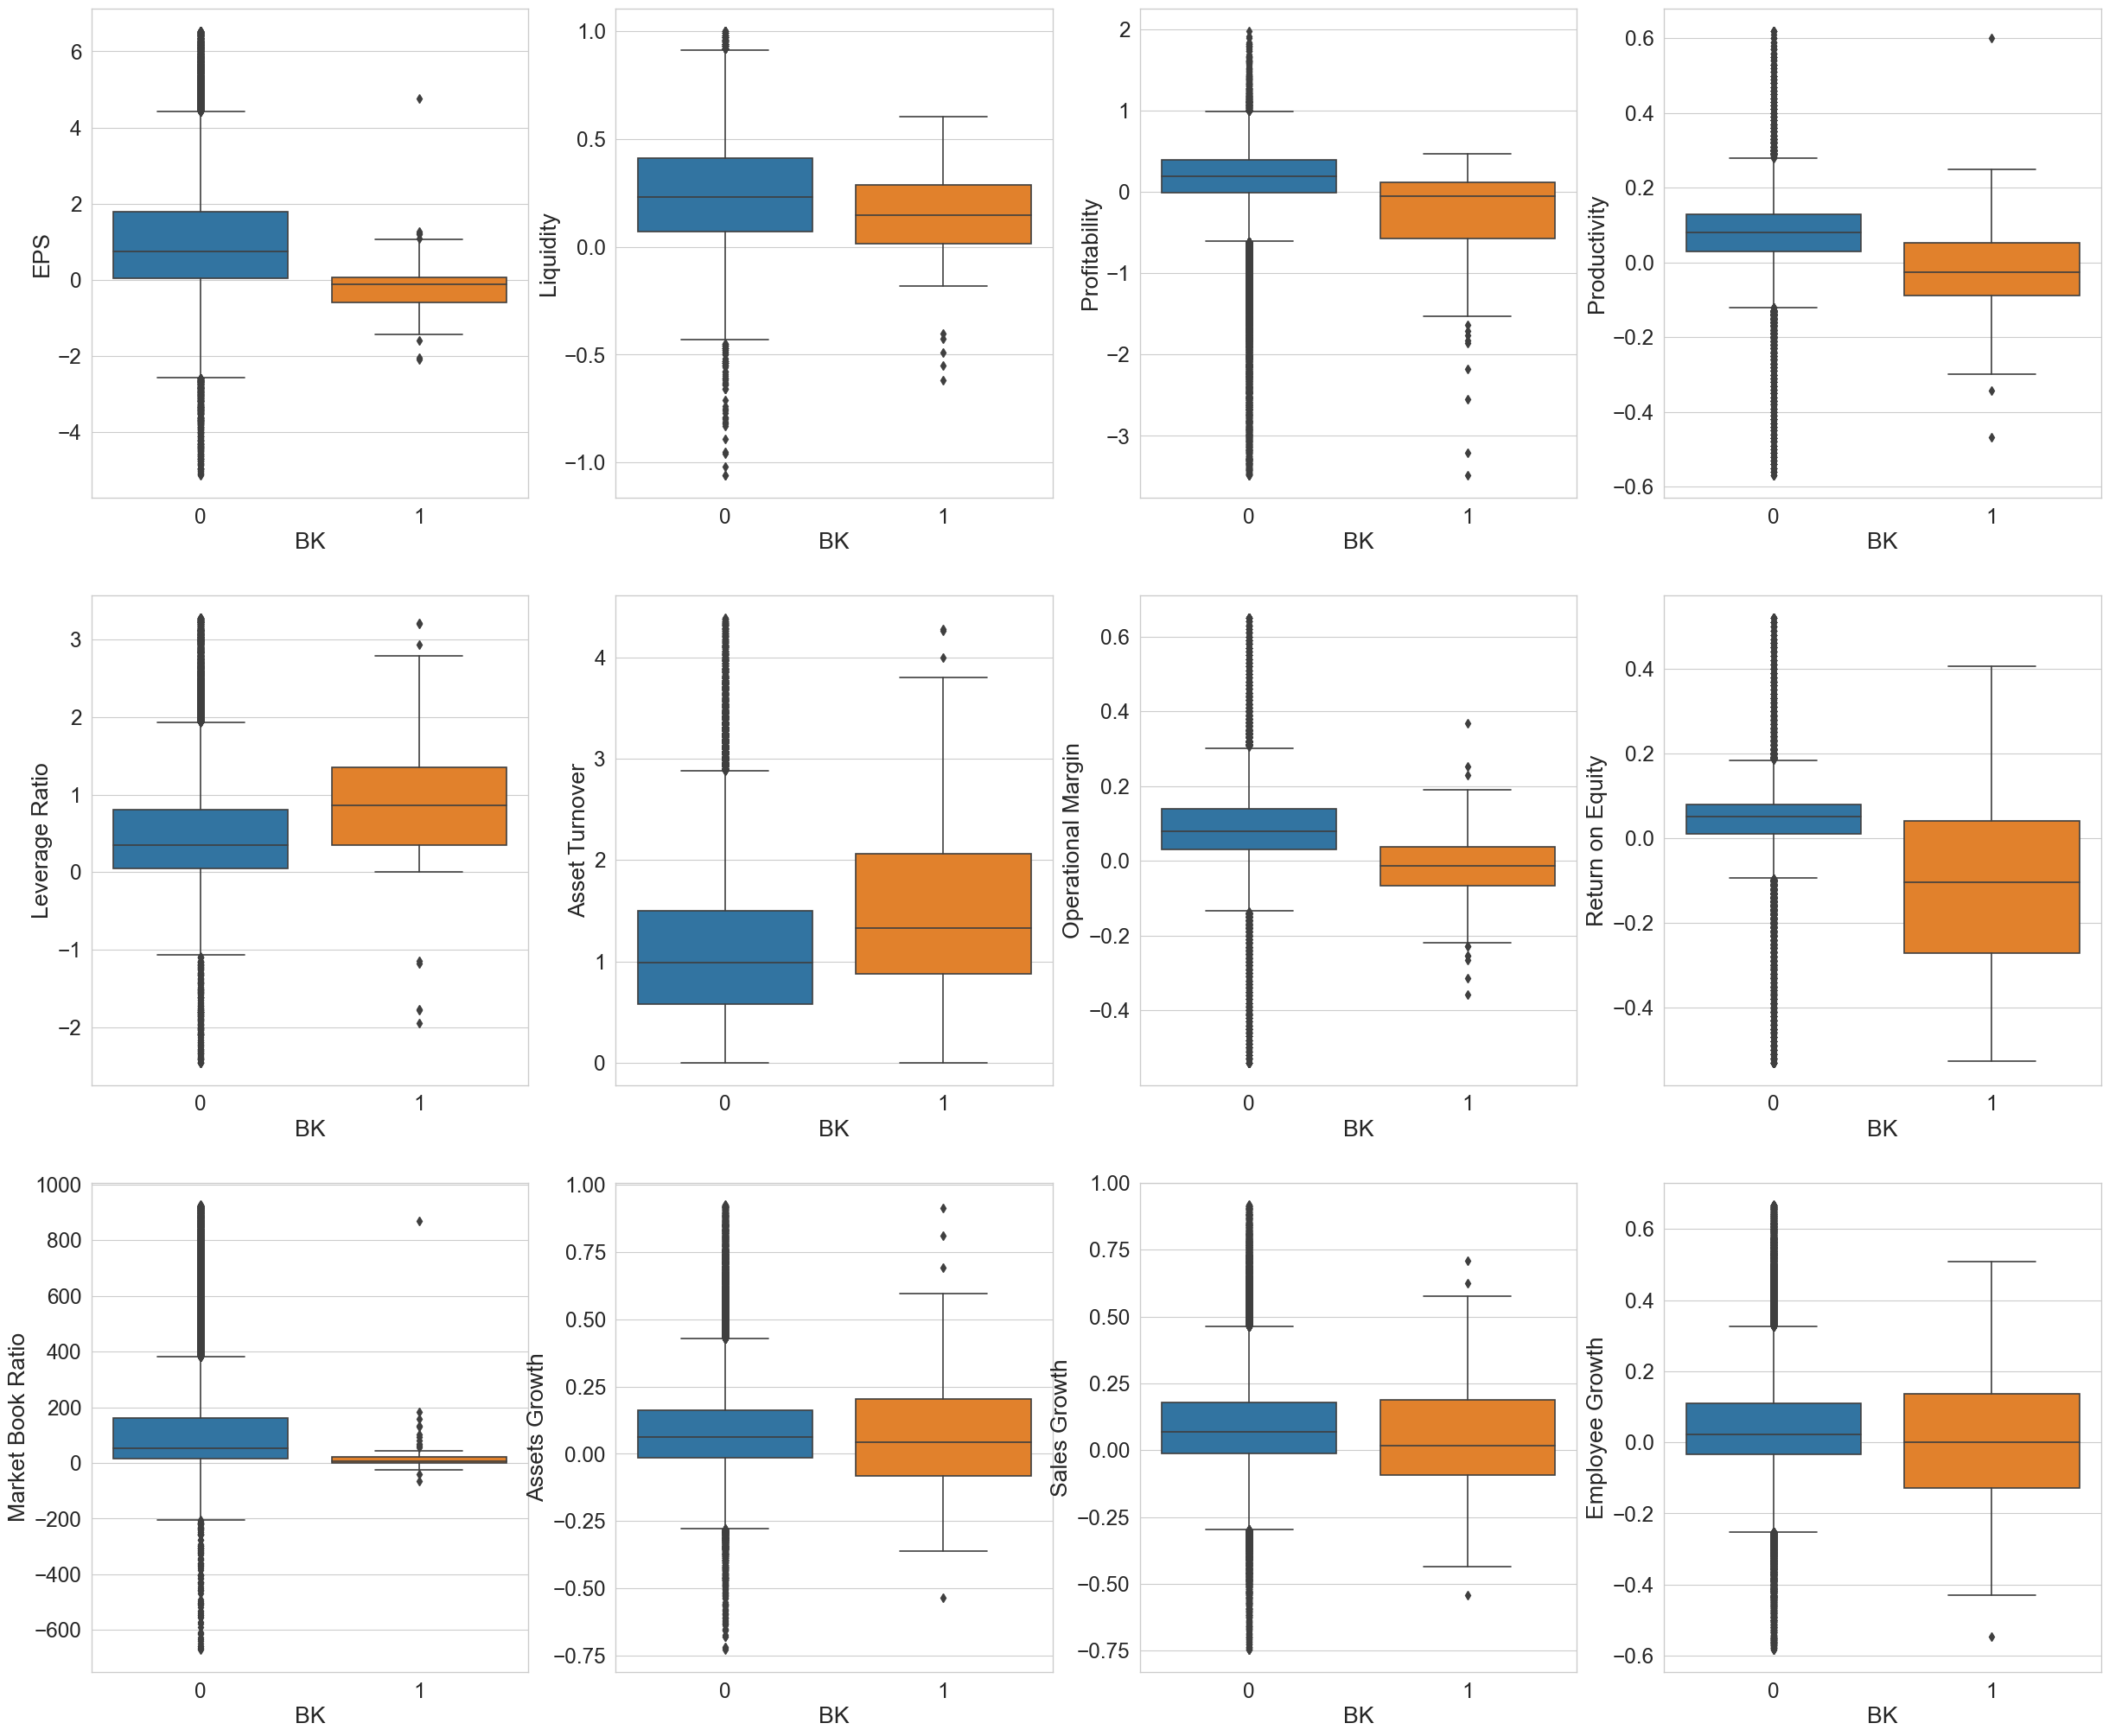

In [30]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,25))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,data=df_noOutliers,x='BK',ax=axes[row,col]);

In [31]:
df_noOutliers.shape

(54239, 13)

In [32]:
df_noOutliers["BK"].value_counts() 

0    54157
1       82
Name: BK, dtype: int64

#### 3.2.1) Checking Effect of Winsorizing Outliers on Dataset
#### 3.2.1) Aykırı Değerleri Kazandırmanın Veri Kümesi Üzerindeki Etkisini Kontrol Etme

In [33]:
#Creating a Function to Winsorize each Column of a Dataframe 
#Bir Dataframe'in Her Sütununu Winsorize Etmek İçin Bir İşlev Oluşturma
def winsorize_df(df,lower_limit, upper_limit, columns = df.columns):
    df_winsor = df.copy()
    for col in columns:
        df_winsor[col] = winsorize(df[col], limits = [lower_limit, upper_limit], inplace = False)
    return df_winsor

In [34]:
#Testing Winsorize Function
#Sindirme İşlevini Test Etme
test_winsor = winsorize(df['EPS'],limits = [0.01,0.01],inplace = False)

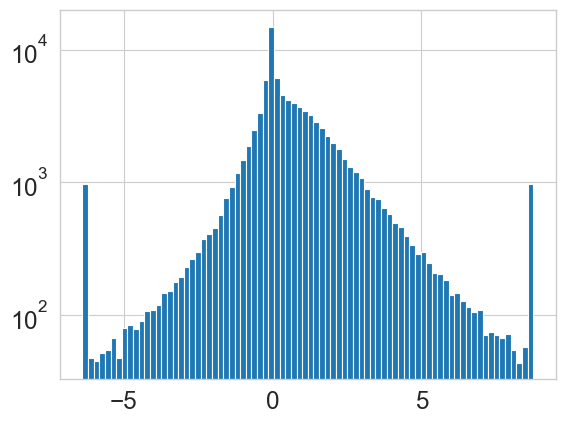

In [35]:
#plt.subplots(figsize = (10,10))
plt.hist(test_winsor,bins = 80,log = True);

In [36]:
df_winsorized = winsorize_df(df,0.05,0.05,independent_variables)

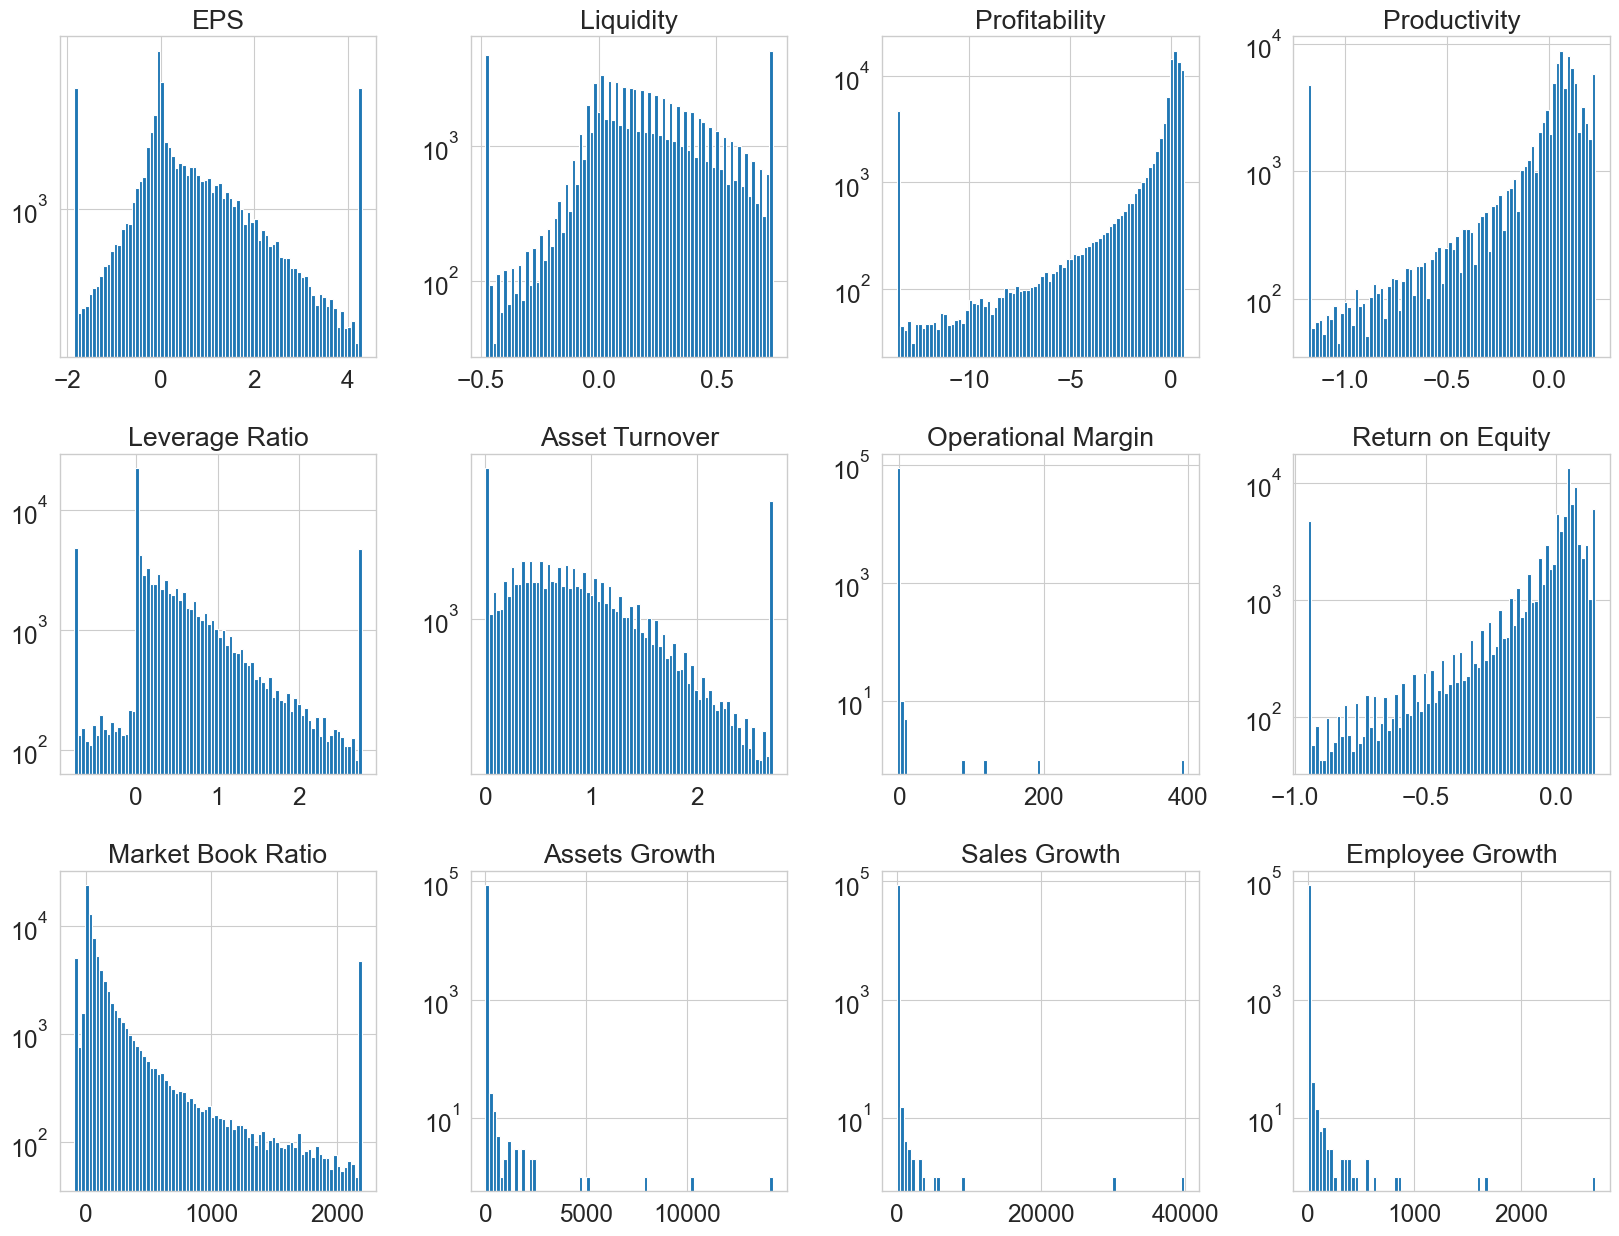

In [37]:
df_winsorized.hist(column = df_independent.columns, bins = 80, figsize = (20,15), layout = (3,4), log = True);

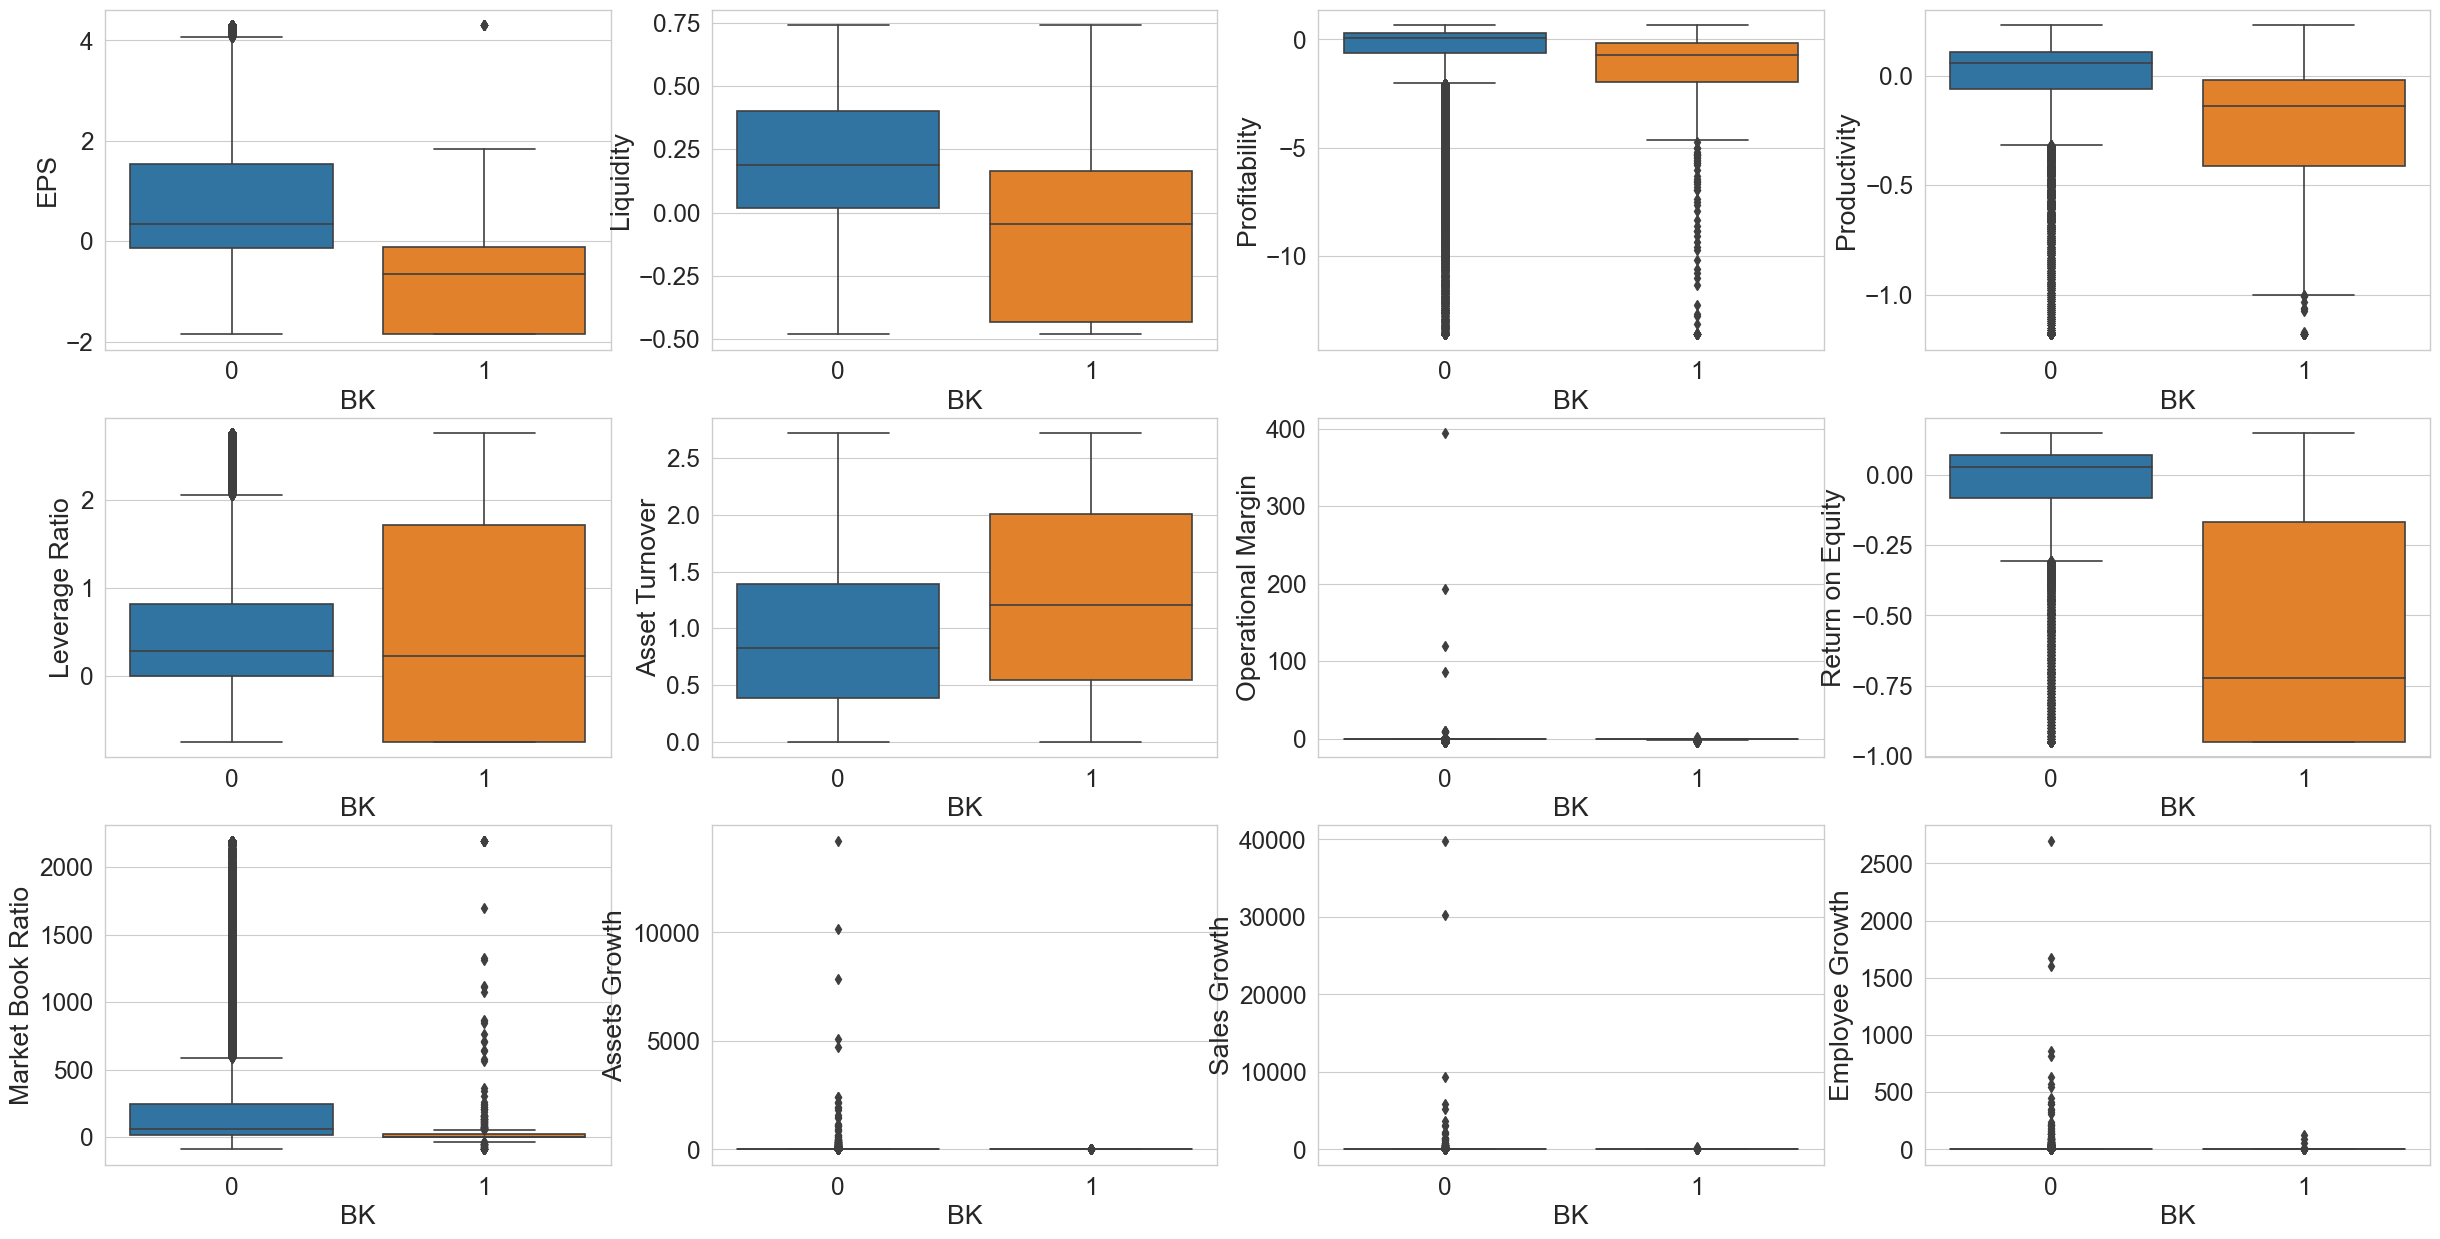

In [38]:
num_cols = df_independent.columns.tolist()
fig,axes = plt.subplots(3,4,figsize=(30,15))
for idx,num_col in enumerate(num_cols):
    row,col = idx//4,idx%4
    g = sns.boxplot(y=num_col,data=df_winsorized,x='BK',ax=axes[row,col]);

In [39]:
df.describe()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92840.0000,92598.0000,92598.0000,92598.0000,92819.0000,92598.0000,87288.0000,92837.0000,92788.0000,86152.0000,86152.0000,85843.0000,92845.0000
mean,-14.4664,-2.6320,-29.5459,-1.2233,1.3454,1.0538,-7.9180,-2.1130,358.5937,1.2943,1.9005,0.3434,0.0060
std,2195.7865,121.6286,677.3292,35.8908,253.0749,2.1162,214.4932,352.6482,26067.4293,73.7777,177.6522,14.0757,0.0773
min,-384000.0000,-25968.5200,-79682.0000,-5093.0000,-7811.0000,-31.5900,-30175.7000,-88875.1400,-3151500.0000,-1.0000,-27.4310,-1.0000,0.0000
25%,-0.1400,0.0200,-0.6400,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2000,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.3050,0.0519,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,240.1700,0.1921,0.2043,0.1310,0.0000
max,55339.0000,1.0000,140.5800,1102.0000,75970.3800,276.3800,394.4700,39500.0000,3455419.3300,14231.0000,39850.0000,2699.0000,1.0000


In [40]:
df_winsorized.describe()

c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92845.0000,92845.0000,92845.0000,92845.0000,92845.0000,92845.0000,87288.0000,92845.0000,92845.0000,86152.0000,86152.0000,85843.0000,92845.0000
mean,0.7245,0.2035,-1.2086,-0.0604,0.5254,0.9684,-0.2260,-0.0716,287.0308,1.3063,1.9166,0.3561,0.0060
std,1.5146,0.2921,3.4357,0.3391,0.8036,0.7418,1.8452,0.2669,560.1953,73.7774,177.6520,14.0749,0.0773
min,-1.8500,-0.4800,-13.5900,-1.1800,-0.7500,0.0000,-3.7600,-0.9500,-92.4000,-0.3701,-0.3944,-0.3214,0.0000
25%,-0.1400,0.0200,-0.6300,-0.0600,0.0000,0.3900,-0.0300,-0.0800,11.2100,-0.0526,-0.0335,-0.0481,0.0000
50%,0.3300,0.1900,0.0700,0.0600,0.2800,0.8300,0.0600,0.0300,58.4100,0.0519,0.0597,0.0172,0.0000
75%,1.5300,0.4000,0.3100,0.1100,0.8200,1.3900,0.1400,0.0700,241.0300,0.1921,0.2043,0.1310,0.0000
max,4.3000,0.7400,0.6500,0.2300,2.7600,2.7200,394.4700,0.1500,2196.7000,14231.0000,39850.0000,2699.0000,1.0000


In [41]:
df_winsorized.shape

(92845, 13)

<div class="alert alert-danger">
<b> Note: </b>
    <li> Removing all samples with extreme outliers results in significant data loss. </li>
    <li> Did not remove outliers in working dataframe. </li>
    <li> Will treat it after train-test split </li>
</div>


<div class="alert alert-tehlike">
<b> Not: </b>
    <li> Aşırı aykırı değerlere sahip tüm örneklerin çıkarılması, önemli veri kaybına neden olur. </li>
    <li> Çalışan veri çerçevesindeki aykırı değerleri kaldırmadı. </li>
    <li> Tren testi ayrımından sonra tedavi edecek </li>
</div>

### 3.3) Check for Missing Values
### 3.3) Eksik Değerleri Kontrol Edin

#### Notes on Missing Value Types
<table>
    <tr>
        <th style = "text-align:center"> Type </th>
        <th style = "text-align:center"> Description </th>
        <th style = "text-align:center"> Recommended Approach </th>
    </tr>
    <tr>
        <td style = "text-align:left"> Missing Completely At Random (MCAR) </td>
        <td style = "text-align:left"> no association with the data you have observed or not observed </td>
        <td style = "text-align:left"> 
            <li> Imputation is advisable
            <li> Do not delete unless there is less than 5% data loss
        </td>
    </tr>
    <tr>
        <td style = "text-align:left"> Missing At Random (MAR) </td>
        <td style = "text-align:left"> depends on data observed, but not data unobserved </td>
        <td style = "text-align:left">
            <li> Impute
            <li> Deleting observations is not appropriate, and will lead to bias
        </td>
    </tr>
        <tr>
        <td style = "text-align:left"> Missing Not At Random (MNAR) </td>
        <td style = "text-align:left"> related to an unobserved value relevant to the assessment of interest </td>
        <td style = "text-align:left">
            <li> data will be biased from deletion and imputation
            <li> inference can be limited, proceed with caution
        </td>
    </tr>
</table>



#### Eksik Değer Türleriyle İlgili Notlar
<tablo>
    <tr>
        <th style = "text-align:center"> Tür </th>
        <th style = "text-align:center"> Açıklama </th>
        <th style = "text-align:center"> Önerilen Yaklaşım </th>
    </tr>
    <tr>
        <td style = "text-align:left"> Tamamen Rastgele Eksik (MCAR) </td>
        <td style = "text-align:left"> gözlemlediğiniz veya gözlemlemediğiniz verilerle ilişkilendirme yok </td>
        <td style = "text-align:left">
            <li> Takdir tavsiye edilir
            <li> %5'ten az veri kaybı olmadıkça silmeyin
        </td>
    </tr>
    <tr>
        <td style = "text-align:left"> Rastgele Eksik (MAR) </td>
        <td style = "text-align:left"> gözlemlenen verilere bağlıdır, ancak gözlemlenmeyen verilere bağlı değildir </td>
        <td style = "text-align:left">
            <li> İtiraf
            <li> Gözlemlerin silinmesi uygun değildir ve önyargıya yol açar
        </td>
    </tr>
        <tr>
        <td style = "text-align:left"> Rastgele Değil (MNAR) </td>
        <td style = "text-align:left"> ilgi değerlendirmesiyle ilgili gözlemlenmemiş bir değerle ilgili </td>
        <td style = "text-align:left">
            <li> veriler, silme ve atamadan saptırılacaktır
            <li> çıkarım sınırlandırılabilir, dikkatli ilerleyin
        </td>
    </tr>
</tablo>

#### 3.3.1) Check on Overall Dataset
#### 3.3.1) Genel Veri Kümesini Kontrol Edin

In [42]:
#defining a function to check on missing data
#eksik verileri kontrol etmek için bir işlev tanımlama
def checkmissing_df(df,index_name = ""):
    
    count_missing = df.isnull().sum()
    percent_missing = count_missing * 100 / len(df)
    missing_value_df = pd.DataFrame({'counts_missing': count_missing,'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True, ascending = False)
    missing_value_df.index.name = index_name
    
    return missing_value_df

In [43]:
# checking on counts and percentage of missing data
# eksik verilerin sayısını ve yüzdesini kontrol etme
missingsamples_df = checkmissing_df(df,index_name = "Columns_All")
missingsamples_df

,counts_missing,percent_missing
Columns_All,,
Employee Growth,7002,7.5416
Assets Growth,6693,7.2088
Sales Growth,6693,7.2088
Operational Margin,5557,5.9852
Liquidity,247,0.2660
Profitability,247,0.2660
Productivity,247,0.2660
Asset Turnover,247,0.2660
Market Book Ratio,57,0.0614


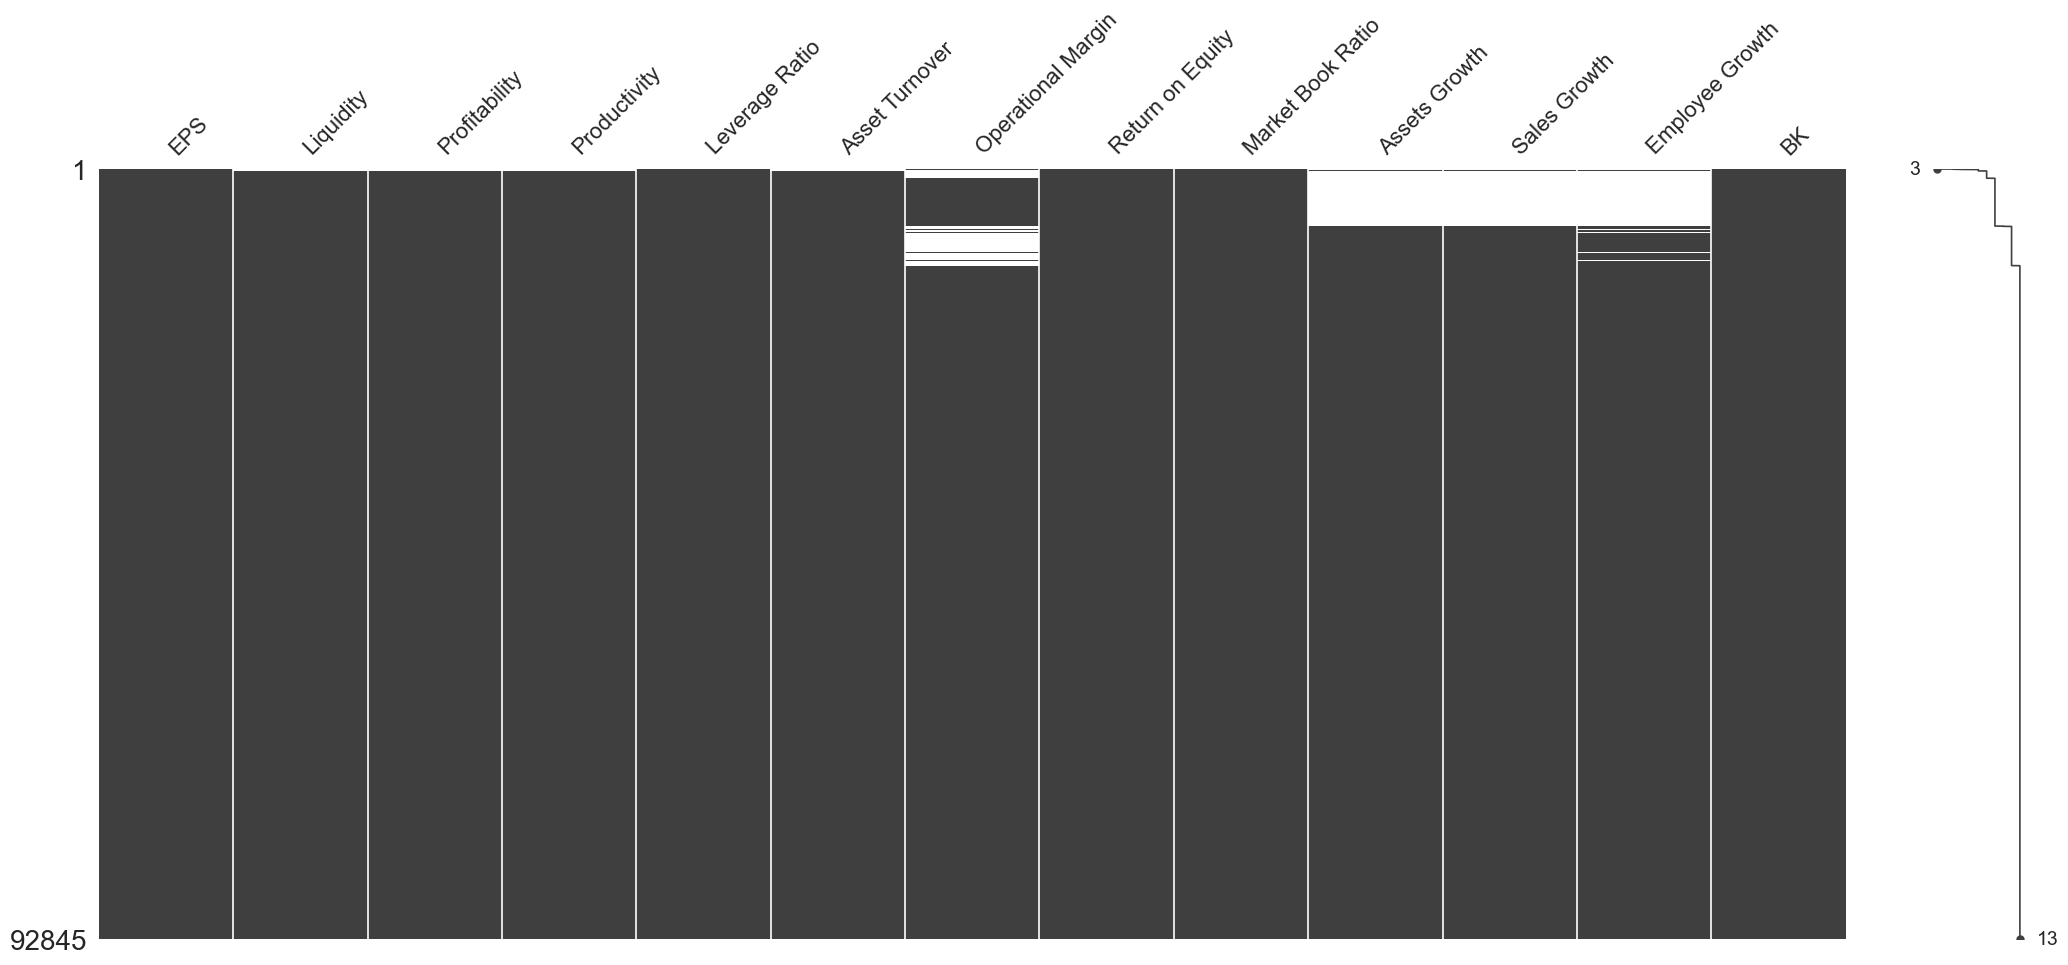

In [44]:
# visualizing if there are blocks of data that are missing together
# birlikte eksik veri blokları olup olmadığını görselleştirme
msno.matrix(df,sort = "ascending");

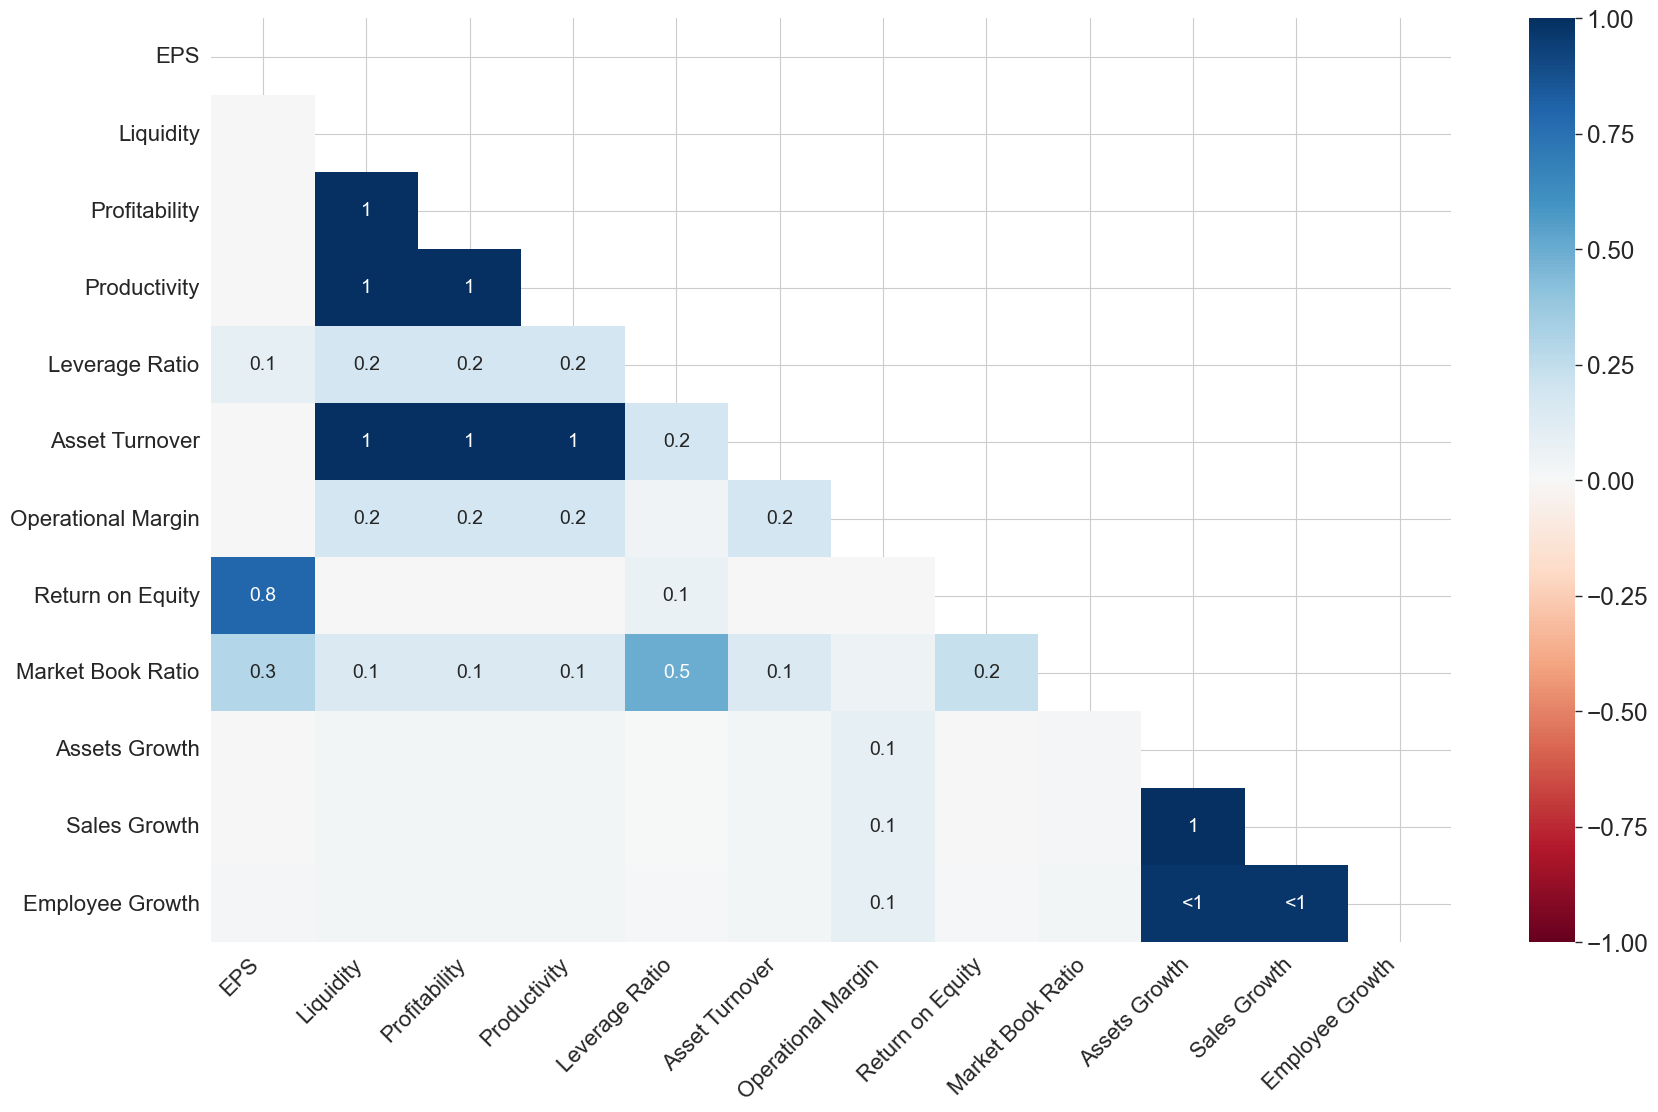

In [45]:
# visualizing correlations of missingness between columns
# sütunlar arasındaki eksiklik korelasyonlarının görselleştirilmesi
msno.heatmap(df);

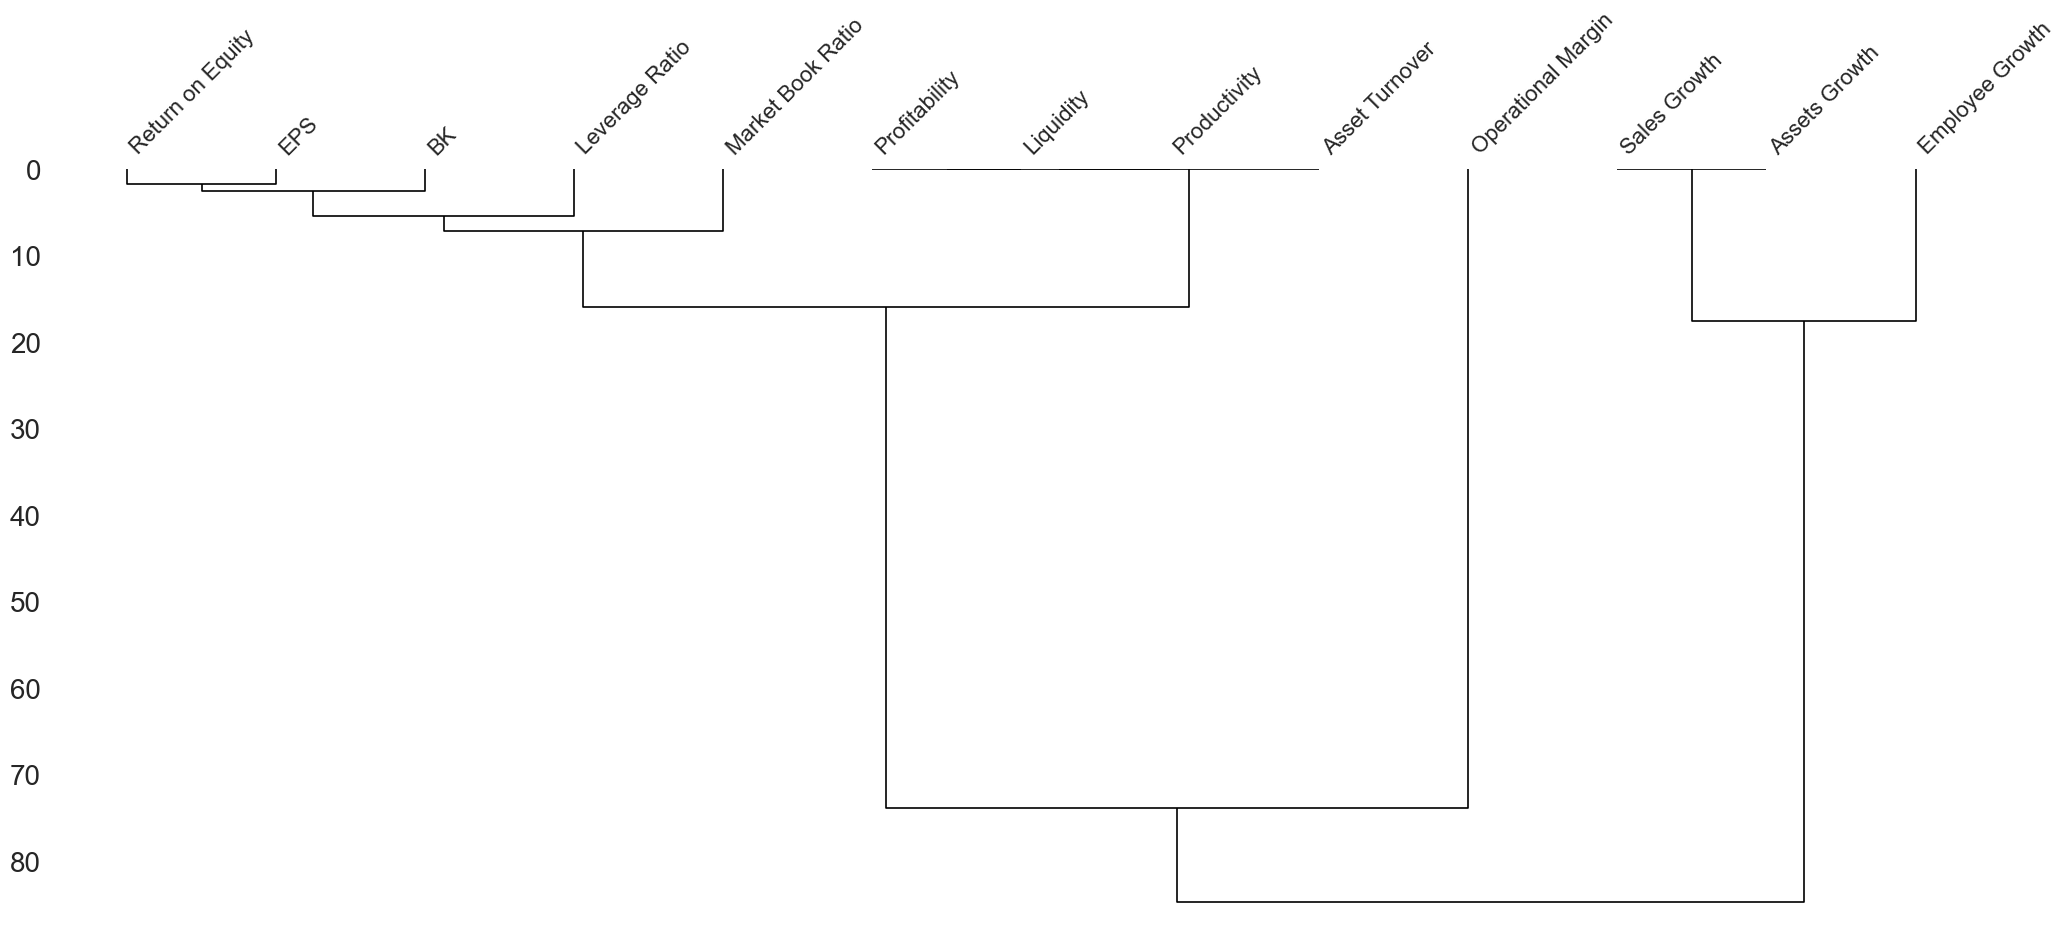

In [46]:
# Grouping columns which are missing together
# Eksik olan sütunların gruplandırılması
msno.dendrogram(df);

<div class="alert alert-info">
<h4>Observations:</h4>
<br>   
<li> None of the features need to be dropped since percentage of missing records per feature are all below 20%
<li> High correlation between Asset Turnover, Profitability, Productivity, and Liquitidy; 100% overlap in records w/ missing data in these features
<li> High correlation between Assets Growth, Sales Growth; 100% overlap in records w/ missing data in these features, These two are also highly correlated with Employee growth
<li> High correlation between ROE and EPS
<li> Somewhat high correlation between Leverage Ratio and Market Book Ratio



<div class="alert alert-info">

<h4>Gözlemler:</h4>

<br>
<li> Özellik başına eksik kayıtların yüzdesi %20'nin altında olduğundan hiçbir özelliğin kaldırılması gerekmez
<li> Varlık Ciro, Kârlılık, Verimlilik ve Likidite arasında yüksek korelasyon; Bu özelliklerde eksik verilerle kayıtlarda %100 örtüşme
<li> Varlık Büyümesi, Satış Büyümesi arasında yüksek korelasyon; Bu özelliklerde eksik verilerle kayıtlarda %100 örtüşme, Bu ikisi aynı zamanda Çalışan büyümesi ile yüksek oranda ilişkilidir
<li> ROE ve EPS arasında yüksek korelasyon
<li> Kaldıraç Oranı ile Piyasa Defter Oranı arasında biraz yüksek korelasyon

#### 3.3.2) Check on Bankruptcy (Rare Events) subset
#### 3.3.2) İflas Kontrolü (Nadir Olaylar) alt kümesi

In [47]:
df_bankrupt = df[(df['BK']==1)]

In [48]:
df_bankrupt.shape

(558, 13)

In [49]:
# checking count and percentage of missing data
# eksik verilerin sayısı ve yüzdesi kontrol ediliyor
checkmissing_df(df_bankrupt, "Columns_Bankrupt")

,counts_missing,percent_missing
Columns_Bankrupt,,
Employee Growth,72,12.9032
Operational Margin,17,3.0466
Market Book Ratio,9,1.6129
EPS,4,0.7168
Return on Equity,4,0.7168
Leverage Ratio,1,0.1792
Liquidity,0,0.0000
Profitability,0,0.0000
Productivity,0,0.0000


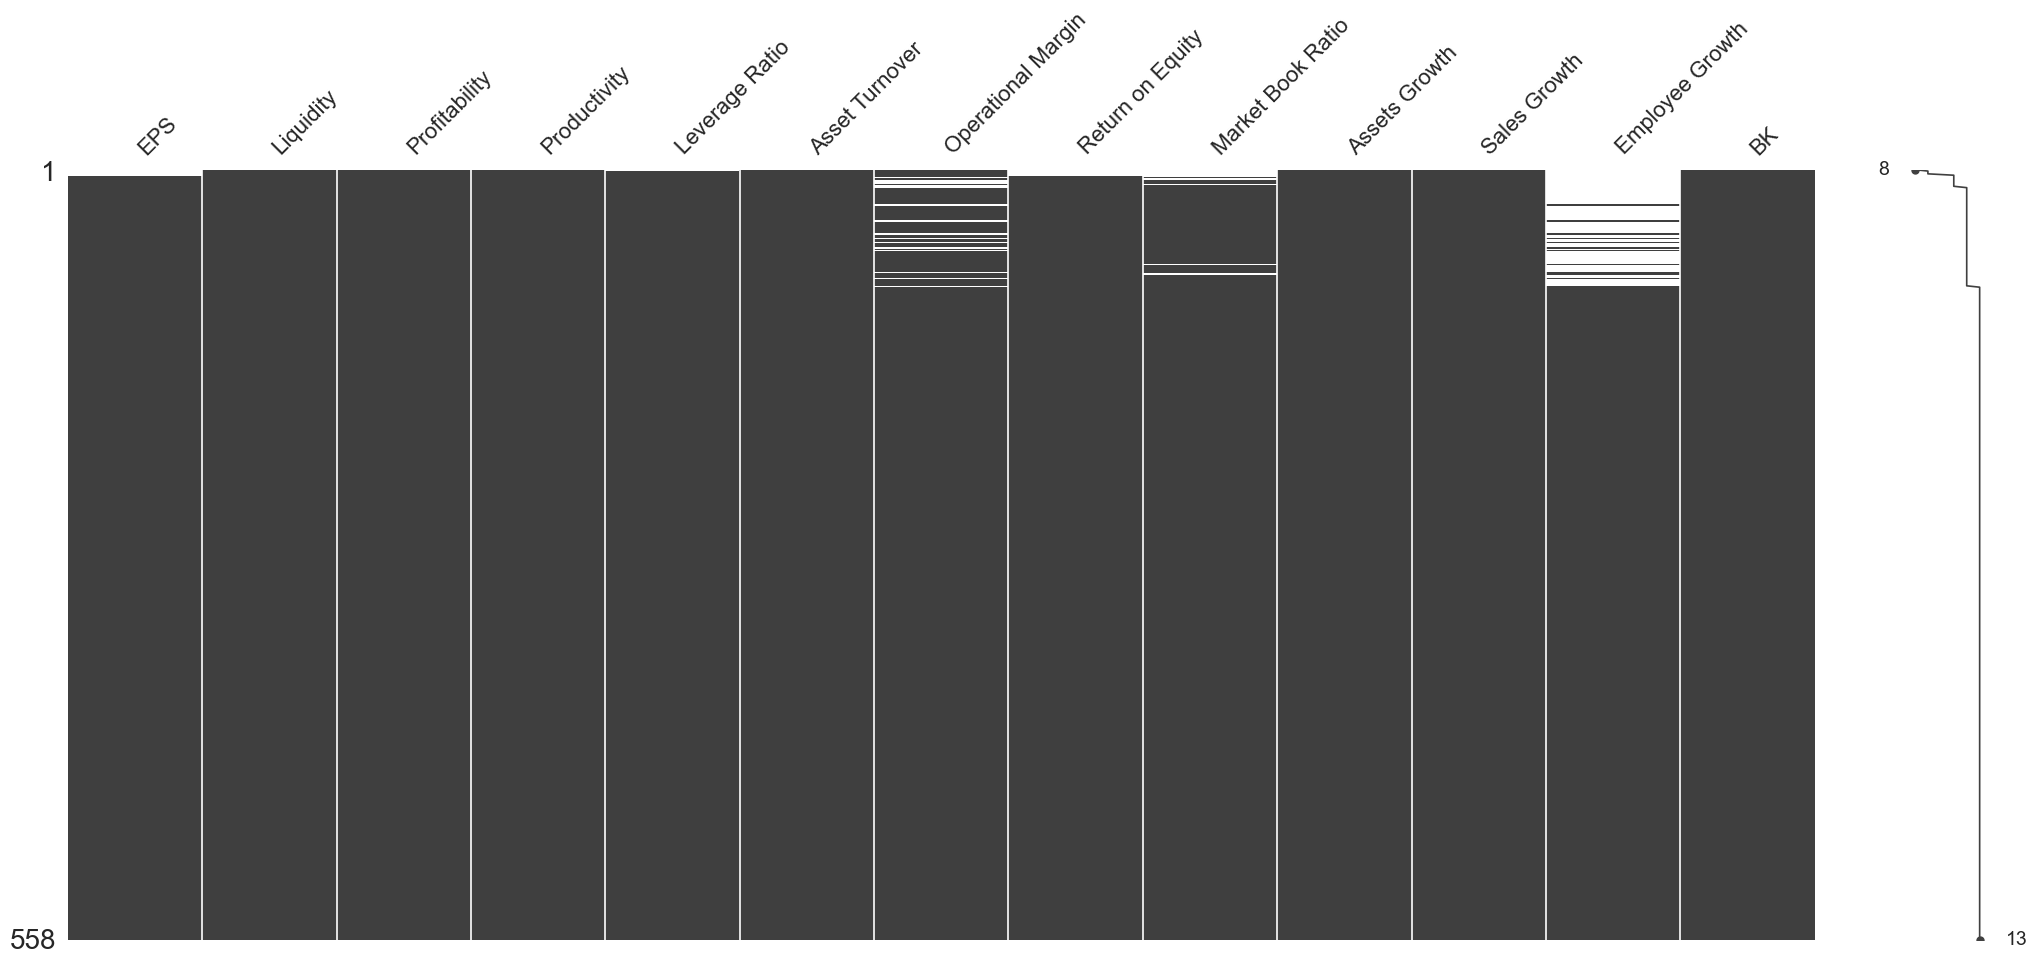

In [50]:
# visualizing if there are blocks of data that are missing together
# birlikte eksik veri blokları olup olmadığını görselleştirme
msno.matrix(df_bankrupt,sort = "ascending");

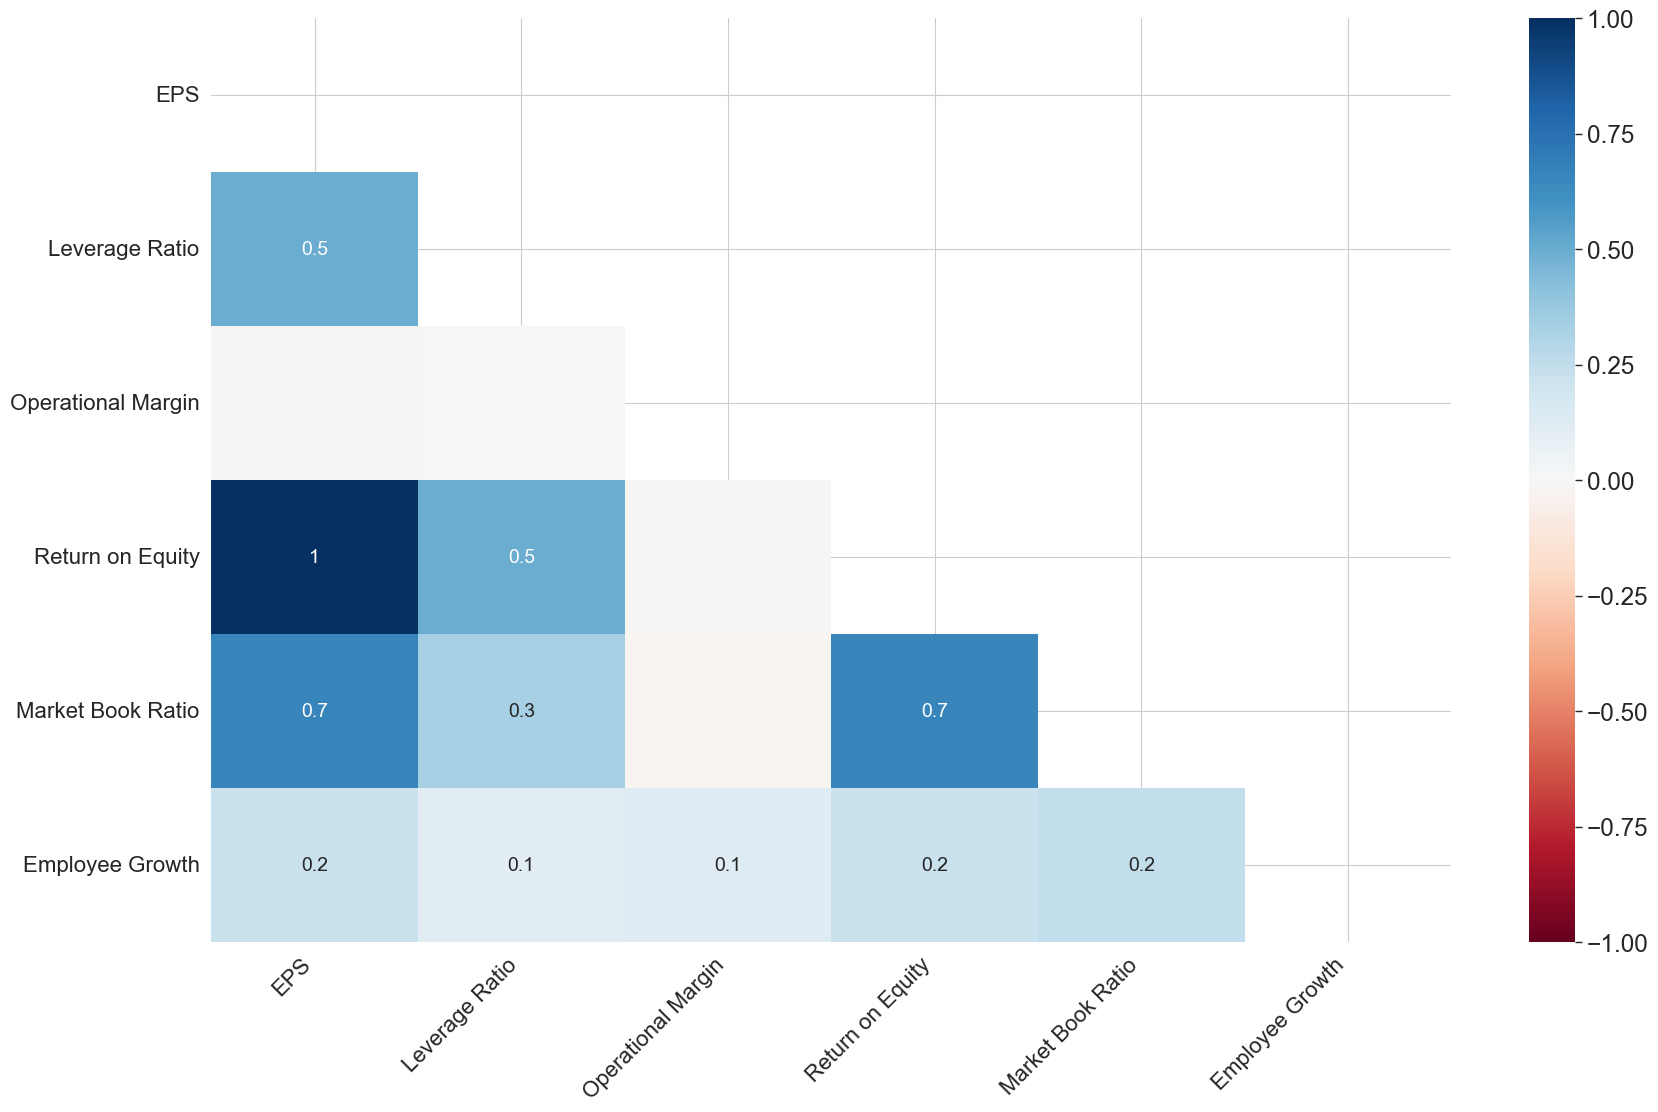

In [51]:
# visualizing correlations of missingness between features
# özellikler arasındaki eksiklik korelasyonlarının görselleştirilmesi
msno.heatmap(df_bankrupt);

<div class="alert alert-info">
    <h4> Observations among bankrupt samples </h4>
<br>
<li> Samples with missing data in ROE are also missing EPS (100% overlap)
<li> High correlation between EPS and Market Book Ratio
<li> High correlation between ROE and Market Book Ratio

<div class="alert alert-info">
    <h4> İflas eden numuneler arasındaki gözlemler </h4>
<br>
<li> ROE'de eksik veri bulunan numunelerde EPS de eksiktir (%100 örtüşme)
<li> EPS ve Piyasa Defter Oranı arasında yüksek korelasyon
<li> ROE ve Piyasa Defter Oranı arasında yüksek korelasyon

<div class="alert alert-danger">
<b> Note: </b> Missing values and outliers will be treated after the train-test split
</div>

<div class="alert alert-tehlike">
<b> Not: </b> Eksik değerler ve aykırı değerler, tren testi bölünmesinden sonra ele alınacaktır
</div>

--------------

## 4) Data Pre-processing
## 4) Veri Ön İşleme

### 4.1) Train-Test Split
### 4.1) Tren Testi Bölümü

In [52]:
# Separate the Features and the Target Variable
# Özellikleri ve Hedef Değişkeni Ayırın
X = df.drop('BK',axis=1)
y = df['BK']

In [53]:
# Split the dataset into training and test sets
# Veri setini eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
# Check dimensions of the splits
# Bölmelerin boyutlarını kontrol edin
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69633, 12), (23212, 12), (69633,), (23212,))

### 4.2) Imputing Missing Values
### 4.2) Eksik Değerleri Atama

In [55]:
# Instantiate the Algorithm
# Algoritmayı somutlaştırın
imputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False,
)

In [56]:
# Fit the imputer to the training data
# Bilgisayarı eğitim verilerine uygun hale getirin
imputer.fit(X_train)

KNNImputer(weights='distance')

In [57]:
# Fill in Missing Values in the Training and Test Data
# Eğitim ve Test Verilerindeki Eksik Değerleri Doldurun
train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [58]:
# Create Dataframe for complete values
# Tam değerler için Veri Çerçevesi oluşturun
train_t = pd.DataFrame(train_t, columns=X_train.columns)
test_t = pd.DataFrame(test_t, columns=X_test.columns)

In [59]:
train_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,-0.0300,0.9800,-0.1300,-0.1000,0.0000,0.0000,-20.0132,-0.0200,103.4900,1913.0000,0.0000,0.0000
1,-0.0100,-7.6600,-36.9600,-2.9200,-0.3800,0.0000,-27.6601,-0.0800,-263.9300,3.0360,-1.0000,0.0000
2,-0.4300,0.3100,-0.1700,-0.0900,0.0100,0.6400,-0.1400,-0.1700,37.0200,-0.0179,-0.0727,0.0034


In [60]:
test_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814
1,0.6700,0.1500,0.1100,0.3300,0.0000,0.7600,0.4400,0.1800,28.7700,3.7753,79.5067,0.3333
2,4.8000,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.4571


### 4.3) Treating Outliers
### 4.3) Aykırı Değerleri İşleme

<b> Options for Treating Outliers: </b>
1. Trimming - removing outliers from the dataset

2. Imputation - substituting outliers using mean, median, or mode

3. Flooring & Capping - replacing outliers with upper and lower boundaries/ control limits for outliers

4. Winsorization - Any value of a variable above or below a percentile k on each side of the variables’ distribution is replaced with the value of the k-th percentile itself

<b> Method Used: </b> Winsorization

<b> Aykırı Değerleri İşleme Seçenekleri: </b>
1. Kırpma - veri kümesinden aykırı değerleri kaldırma

2. Takdir - ortalama, medyan veya modu kullanarak aykırı değerlerin değiştirilmesi

3. Döşeme ve Kapaklama - aykırı değerlerin üst ve alt sınırlar/ aykırı değerler için kontrol limitleri ile değiştirilmesi

4. Winsorization - Bir değişkenin, değişken dağılımının her iki tarafındaki bir yüzdelik k'nin üzerindeki veya altındaki herhangi bir değeri, k'inci yüzdelik değerin kendi değeriyle değiştirilir.

<b> Kullanılan Yöntem: </b> Winsorizasyon


In [61]:
# Defining a function to find the upper and lower boundaries of outliers in a certain variable
# Belirli bir değişkende aykırı değerlerin üst ve alt sınırlarını bulan bir fonksiyon tanımlama
def find_winsorboundaries(df, variable, lower_limit, upper_limit):

    lower_boundary = df[variable].quantile(lower_limit)
    upper_boundary = df[variable].quantile(1-upper_limit)

    return upper_boundary, lower_boundary

In [62]:
# display boundaries
# sınırları göster
for column in train_t:
        RM_upper_limit, RM_lower_limit = find_winsorboundaries(X_train, column, 0.05,0.05)
        print(f'The limits for column ({column}) are {round(RM_upper_limit,2), round(RM_lower_limit,2)}')

The limits for column (EPS) are (4.34, -1.86)
The limits for column (Liquidity) are (0.73, -0.47)
The limits for column (Profitability) are (0.64, -13.71)
The limits for column (Productivity) are (0.23, -1.19)
The limits for column (Leverage Ratio) are (2.73, -0.75)
The limits for column (Asset Turnover) are (2.67, 0.0)
The limits for column (Operational Margin) are (0.31, -4.23)
The limits for column (Return on Equity) are (0.16, -0.95)
The limits for column (Market Book Ratio) are (2159.11, -91.03)
The limits for column (Assets Growth) are (1.04, -0.39)
The limits for column (Sales Growth) are (0.97, -0.42)
The limits for column (Employee Growth) are (0.67, -0.33)


In [63]:
# Applying Winsorization to All Columns
# Tüm Sütunlara Winsorizasyon Uygulamak
for column in train_t:
        RM_upper_limit, RM_lower_limit = find_winsorboundaries(X_train, column, 0.05,0.05)
        train_t[column]= np.where(train_t[column] > RM_upper_limit, RM_upper_limit,
                       np.where(train_t[column] < RM_lower_limit, RM_lower_limit, train_t[column]))
        test_t[column]= np.where(test_t[column] > RM_upper_limit, RM_upper_limit, 
                       np.where(test_t[column] < RM_lower_limit, RM_lower_limit, test_t[column]))

#### Display Data
#### Verileri Görüntüle

In [64]:
train_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,-0.0300,0.7300,-0.1300,-0.1000,0.0000,0.0000,-4.2300,-0.0200,103.4900,1.0440,0.0000,0.0000
1,-0.0100,-0.4700,-13.7085,-1.1900,-0.3800,0.0000,-4.2300,-0.0800,-91.0285,1.0440,-0.4203,0.0000
2,-0.4300,0.3100,-0.1700,-0.0900,0.0100,0.6400,-0.1400,-0.1700,37.0200,-0.0179,-0.0727,0.0034


In [65]:
test_t.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth
0,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814
1,0.6700,0.1500,0.1100,0.2300,0.0000,0.7600,0.3100,0.1599,28.7700,1.0440,0.9699,0.3333
2,4.3400,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.3333


### 4.4) Resampling Imbalanced Training Data
### 4.4) Dengesiz Egzersiz Verilerini Yeniden Örnekleme

In [66]:
# Instantiate SMOTE
# SMOTE'u başlat
sm = SMOTE(
    sampling_strategy='auto',  
    random_state=21,  
    k_neighbors=5,
    n_jobs=-1
)

In [67]:
# Instantiate ENN
# ENN'yi somutlaştırın
enn = EditedNearestNeighbours(
    sampling_strategy='auto',
    n_neighbors=3,
    kind_sel='all',
    n_jobs=-1)

In [68]:
# Combine Rebalancing Methods
# Yeniden Dengeleme Yöntemlerini Birleştirin
method = SMOTEENN(
    sampling_strategy='auto',  
    random_state=21,  
    smote=sm,
    enn=enn,
    n_jobs=-1
)

#### Applying Chosen Method to Training Data
#### Seçilen Yöntemi Eğitim Verilerine Uygulama

In [69]:
# Apply resampling to training data only
# Yeniden örneklemeyi yalnızca eğitim verilerine uygulayın
x_resampled, y_resampled = method.fit_resample(train_t,y_train)

c:\Users\Serkan POLAT\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


### 4.5) Scale the Dataset
### 4.5) Veri Kümesini Ölçeklendirin

Robust Scaler is not influenced by large, marginal outliers. (<a href= "https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler">Source</a>)

Sağlam Ölçekleyici, büyük, marjinal aykırı değerlerden etkilenmez. (<a href= "https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#robustscaler">Kaynak</a>)

In [70]:
# NOTE: Only scale the predictor variables, NOT the target variable
# NOT: Hedef değişkeni DEĞİL, yalnızca tahmin değişkenlerini ölçeklendirin

scaler = RobustScaler()

x_train_scaled = scaler.fit_transform(x_resampled)

x_test_scaled = scaler.transform(test_t)

### 4.6) Final Variables to be Used on Models

- x_train_scaled

- y_resampled


- x_test_scaled

- y_test

### 4.6) Modellerde Kullanılacak Son Değişkenler

- x_train_scaled

- y_yeniden örneklendi


- x_test_scaled

- y_testi

----------------------

## 5) Logistic Regression

### 5.1) Train the Model

In [71]:
# Instantiate the Algorithm 
# Algoritmayı somutlaştırın
logreg = LogisticRegression()

In [72]:
# Train the model
# Modeli eğit
logreg.fit(x_train_scaled,y_resampled)

LogisticRegression()

In [73]:
# Create a DataFrame for easy understanding. 1st Column will be Feature Names, 2nd column will be the Coef values
# Kolay anlaşılması için bir DataFrame oluşturun. 1. Sütun Özellik Adları, 2. Sütun Katsayı değerleri olacaktır

coef = pd.DataFrame(X_train.columns, columns=["Features"])

coef['Coef'] = logreg.coef_.reshape(-1,1)

coef_sorted = coef.sort_values("Coef", ascending=False)

coef_sorted.head(10)

,Features,Coef
5,Asset Turnover,0.8683
4,Leverage Ratio,0.4720
2,Profitability,0.2838
9,Assets Growth,0.2621
6,Operational Margin,0.0487
11,Employee Growth,0.0212
10,Sales Growth,0.0171
8,Market Book Ratio,-0.0859
0,EPS,-0.5513
3,Productivity,-0.6630


### 5.2) Predicting on Test Set
### 5.2) Test Setinde Öngörüde Bulunma

In [74]:
# Predict on the Test Set
# Test Setinde Tahmin
y_pred = logreg.predict(x_test_scaled)

y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
# Predict probabilities using the "predict_proba" function
# "predict_proba" işlevini kullanarak olasılıkları tahmin edin
y_prob = logreg.predict_proba(x_test_scaled)

y_prob

array([[0.81590276, 0.18409724],
       [0.85137057, 0.14862943],
       [0.81992789, 0.18007211],
       ...,
       [0.8836323 , 0.1163677 ],
       [0.79093726, 0.20906274],
       [0.80817819, 0.19182181]])

In [76]:
# Check the shape, there should be two columns, one for each class
# Şekli kontrol edin, her sınıf için bir tane olmak üzere iki sütun olmalıdır
y_prob.shape

(23212, 2)

In [77]:
# Create a DataFrame
# Bir DataFrame oluşturun
y_prob_df = pd.DataFrame(y_prob, index=y_test.index)

In [78]:
y_prob_df.head()

,0,1
49952,0.8159,0.1841
42044,0.8514,0.1486
34880,0.8199,0.1801
45390,0.8733,0.1267
77462,0.2778,0.7222


In [79]:
X_test.shape

(23212, 12)

In [80]:
# Put all information on a DataFrame for analysis
# Analiz için tüm bilgileri bir DataFrame'e koyun

# Copy test data
# Test verilerini kopyala
df_results = X_test.copy()

# Add actual, predicted, and predicted probability results
# Gerçek, tahmin edilen ve tahmin edilen olasılık sonuçlarını ekleyin
df_results["Predicted_Prob_0"] = y_prob_df[0]
df_results["Predicted_Prob_1"] = y_prob_df[1]
df_results["Actual_Class"] = y_test
df_results["Predicted_Class"] = y_pred

labels = logreg.classes_

In [81]:
df_results.head(3)

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,Predicted_Prob_0,Predicted_Prob_1,Actual_Class,Predicted_Class
49952,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814,0.8159,0.1841,0,0
42044,0.6700,0.1500,0.1100,0.3300,0.0000,0.7600,0.4400,0.1800,28.7700,3.7753,79.5067,0.3333,0.8514,0.1486,0,0
34880,4.8000,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.4571,0.8199,0.1801,0,0


### 5.3) Check Model Performance
### 5.3) Model Performansını Kontrol Edin

#### 5.3.1) Confusion Matrix

In [82]:
# Get the Confusion Matrix
# Karışıklık Matrisini Alın
cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)

# Put in DataFrame
# DataFrame'e koy
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# View the DataFrame
# DataFrame'i görüntüle
cm_df

,0,1
0,19850,3211
1,41,110


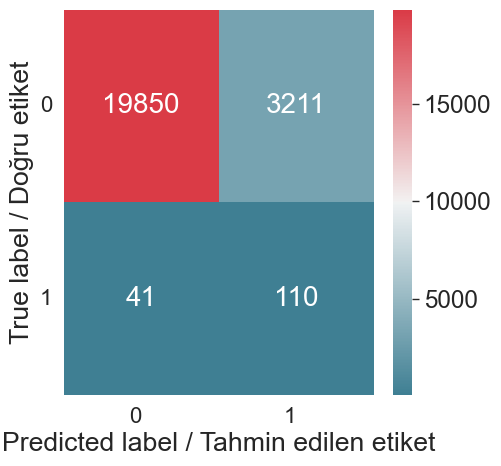

In [83]:
# Plot the confusion matrix for easier viewing
# Daha kolay görüntüleme için karışıklık matrisini çizin


# Plot Attributes
# Grafik Nitelikleri
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Seaborn Heatmap - passing confusion matrix
# Seaborn Isı Haritası - kafa karışıklığı matrisini geçme
heatmap = sns.heatmap(cm_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)

# Heatmap attributes
# Isı haritası özellikleri
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label / Doğru etiket')
plt.xlabel('Predicted label / Tahmin edilen etiket');

#### 5.3.2) Key Performance Metrics
#### 5.3.2) Temel Performans Metrikleri

In [84]:
# Defining a function to get Key metrics
# Anahtar ölçümleri almak için bir işlev tanımlama

def get_metrics(target,predicted,predicted_prob):
    accuracy = round(metrics.accuracy_score(target,predicted)*100,2)
    error = round(100 - accuracy,2)
    precision = metrics.precision_recall_fscore_support(target,predicted)[0][1]
    recall = metrics.precision_recall_fscore_support(target,predicted)[1][1]
    f1 = metrics.precision_recall_fscore_support(target,predicted)[2][1]
    auc = metrics.roc_auc_score(target,predicted_prob)
    classification_report = metrics.classification_report(target,predicted, digits = 4)
    
    
    print(f'''Accuracy / Doğruluk: {accuracy}% 
Error / Hata : {error}%
''')
    
    print("Classification Report / Sınıflandırma Raporu")
    
    print(classification_report)
    
    print(f'AUC: {round(auc,2)}')
    
    return accuracy, precision, recall, f1, auc

In [85]:
# Get the Probabilities
# Olasılıkları Alın
predict_proba_1 = df_results["Predicted_Prob_1"]

In [86]:
logreg_metrics = get_metrics(y_test,y_pred,predict_proba_1)

Accuracy / Doğruluk: 85.99% 
Error / Hata : 14.01%

Classification Report / Sınıflandırma Raporu
              precision    recall  f1-score   support

           0     0.9979    0.8608    0.9243     23061
           1     0.0331    0.7285    0.0634       151

    accuracy                         0.8599     23212
   macro avg     0.5155    0.7946    0.4938     23212
weighted avg     0.9917    0.8599    0.9187     23212

AUC: 0.87


In [87]:
y_test

49952    0
42044    0
34880    0
45390    0
77462    0
        ..
39945    0
71092    0
69112    0
6409     0
43047    0
Name: BK, Length: 23212, dtype: int64

In [88]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### 5.4) Setting a Different Threshold
### 5.4) Farklı Bir Eşik Ayarlama

In [89]:
# Setting a different threshold for the Regression
# Regresyon için farklı bir eşik belirleme
threshold = .45

y_pred_2 = (y_prob_df[1] >= threshold).astype(int)

y_pred_2

df_results["Predicted_Class_New"] = y_pred_2
df_results.head()

,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,Predicted_Prob_0,Predicted_Prob_1,Actual_Class,Predicted_Class,Predicted_Class_New
49952,1.2400,0.0300,0.1500,0.0600,0.5600,0.6600,0.0900,0.0800,49.8800,0.4120,0.5725,-0.0814,0.8159,0.1841,0,0,0
42044,0.6700,0.1500,0.1100,0.3300,0.0000,0.7600,0.4400,0.1800,28.7700,3.7753,79.5067,0.3333,0.8514,0.1486,0,0,0
34880,4.8000,-0.0200,0.3800,0.0800,0.6600,2.4600,0.0300,0.1300,67.8300,0.0923,0.0522,-0.4571,0.8199,0.1801,0,0,0
45390,2.2100,0.1300,0.2100,0.0700,0.8000,0.4100,0.1800,0.0400,98.1400,0.5620,0.4752,0.5135,0.8733,0.1267,0,0,0
77462,-2.1400,0.1500,0.2000,-0.0200,0.6200,1.1300,-0.0200,-0.4300,19.7700,-0.1177,-0.1432,-0.1359,0.2778,0.7222,0,1,1


In [90]:
# Check performance metrics
# Performans ölçümlerini kontrol edin
accuracy2 = round(metrics.accuracy_score(y_test,y_pred_2)*100,2)
error2 = round(100 - accuracy2,2)
print(f'''Accuracy / Doğruluk: {accuracy2}% 
Error / Hata: {error2}%''')

Accuracy / Doğruluk: 84.19% 
Error / Hata: 15.81%


In [91]:
# Get the Confusion Matrix
# Karışıklık Matrisini Alın
cm2 = metrics.confusion_matrix(y_test, y_pred_2, labels=labels)

# Put in DataFrame
# DataFrame'e koy
cm_df2 = pd.DataFrame(cm2, index=labels, columns=labels)

# View the DataFrame
# DataFrame'i görüntüle
cm_df2

,0,1
0,19425,3636
1,33,118


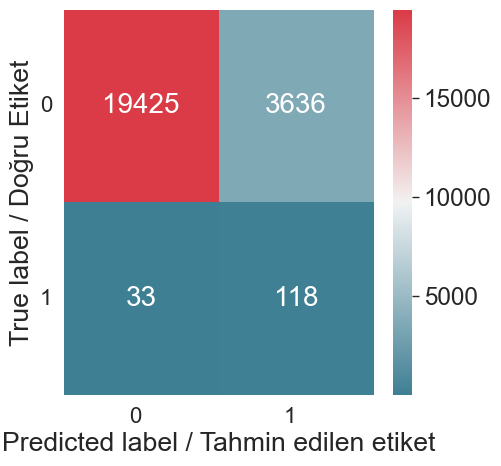

In [92]:
# Plot the confusion matrix for easier viewing
# Daha kolay görüntüleme için karışıklık matrisini çizin

# Plot Attributes
# Grafik Nitelikleri
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Seaborn Heatmap - passing confusion matrix
# Seaborn Isı Haritası - kafa karışıklığı matrisini geçme
heatmap = sns.heatmap(cm_df2,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)

# Heatmap attributes
# Isı haritası özellikleri
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label / Doğru Etiket')
plt.xlabel('Predicted label / Tahmin edilen etiket');

In [93]:
logreg2_metrics = get_metrics(y_test,y_pred_2,predict_proba_1)

Accuracy / Doğruluk: 84.19% 
Error / Hata : 15.81%

Classification Report / Sınıflandırma Raporu
              precision    recall  f1-score   support

           0     0.9983    0.8423    0.9137     23061
           1     0.0314    0.7815    0.0604       151

    accuracy                         0.8419     23212
   macro avg     0.5149    0.8119    0.4871     23212
weighted avg     0.9920    0.8419    0.9082     23212

AUC: 0.87


----------------------

## 6) Random Forest

### 6.1) Train the Model

In [94]:
# Instantiate the Algorithm
# Algoritmayı somutlaştırın
rf_model = RandomForestClassifier(n_estimators=10,max_features='sqrt',random_state=21)

In [95]:
# Train the model
# Modeli eğit
rf_model.fit(x_train_scaled,y_resampled)

RandomForestClassifier(n_estimators=10, random_state=21)

### 6.2) Predicting on Test Set
### 6.2) Test Setinde Öngörüde Bulunma

In [96]:
# Predicting on Test Set
# Test Setinde Tahmin Yapma
y_pred_rf = rf_model.predict(x_test_scaled)

In [97]:
# Predict probabilities using the "predict_proba" function
# "predict_proba" işlevini kullanarak olasılıkları tahmin edin
y_prob_rf = rf_model.predict_proba(x_test_scaled)

In [98]:
# Check the shape, there should be two columns, one for each class
# Şekli kontrol edin, her sınıf için bir tane olmak üzere iki sütun olmalıdır
y_prob_rf.shape

(23212, 2)

In [99]:
# Create a DataFrame
# Bir DataFrame oluşturun
y_prob_df_rf = pd.DataFrame(y_prob_rf, index=y_test.index)

y_prob_df_rf.head(3)

,0,1
49952,1.0000,0.0000
42044,1.0000,0.0000
34880,1.0000,0.0000


### 6.3) Check Model Performance
### 6.3) Model Performansını Kontrol Edin

#### 6.3.1) Confusion Matrix
#### 6.3.1) Karışıklık Matrisi

In [100]:
# Get the Confusion Matrix
# Karışıklık Matrisini Alın
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf, labels=labels)

# Put in DataFrame
# DataFrame'e koy
cm_rf_df = pd.DataFrame(cm_rf, index=labels, columns=labels)

# View the DataFrame
# DataFrame'i görüntüle
cm_rf_df

,0,1
0,22780,281
1,119,32


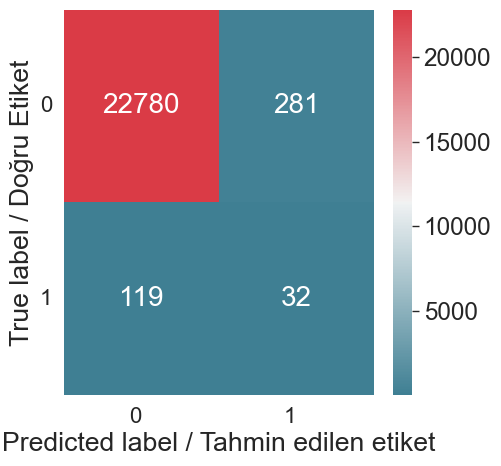

In [101]:
# Plot the confusion matrix for easier viewing
# Daha kolay görüntüleme için karışıklık matrisini çizin


# Plot Attributes
# Grafik Nitelikleri
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Seaborn Heatmap - passing confusion matrix
# Seaborn Isı Haritası - karışıklık matrisini geçme
heatmap = sns.heatmap(cm_rf_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)


# Heatmap attributes
# Isı haritası özellikleri
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)


plt.ylabel('True label / Doğru Etiket')
plt.xlabel('Predicted label / Tahmin edilen etiket')

#### 6.3.2) Key Performance Metrics
#### 6.3.2) Temel Performans Metrikleri

In [102]:
rf_metrics = get_metrics(y_test,y_pred_rf,y_prob_df_rf[1])

Accuracy / Doğruluk: 98.28% 
Error / Hata : 1.72%

Classification Report / Sınıflandırma Raporu
              precision    recall  f1-score   support

           0     0.9948    0.9878    0.9913     23061
           1     0.1022    0.2119    0.1379       151

    accuracy                         0.9828     23212
   macro avg     0.5485    0.5999    0.5646     23212
weighted avg     0.9890    0.9828    0.9857     23212

AUC: 0.83


----------------------

## 7) Naive Bayes

### 7.1) Train the Model

In [103]:
# Instantiate the Algorithm 
# Algoritmayı somutlaştırın
gnb = GaussianNB()

In [104]:
# Train the model
# Modeli eğit
gnb.fit(x_train_scaled,y_resampled)

GaussianNB()

### 7.2) Predicting on Test Set
### 7.2) Test Setinde Öngörüde Bulunma

In [105]:
y_pred_gnb = gnb.predict(x_test_scaled)

In [106]:
y_pred_gnb

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [107]:
# Predict probabilities using the "predict_proba" function
# "predict_proba" işlevini kullanarak olasılıkları tahmin edin
y_prob_gnb = gnb.predict_proba(x_test_scaled)

In [108]:
# Check the shape, there should be two columns, one for each class
# Şekli kontrol edin, her sınıf için bir tane olmak üzere iki sütun olmalıdır
y_prob_gnb.shape

(23212, 2)

In [109]:
# Create a DataFrame
# Bir DataFrame oluşturun
y_prob_df_gnb = pd.DataFrame(y_prob_gnb, index=y_test.index)
s
y_prob_df_gnb.head(3)

,0,1
49952,0.9919,0.0081
42044,0.9973,0.0027
34880,1.0000,0.0000


### 7.3) Check Model Performance
### 7.3) Model Performansını Kontrol Edin

#### 7.3.1) Confusion Matrix

In [110]:
# Get the Confusion Matrix
# Karışıklık Matrisini Alın
cm_gnb = metrics.confusion_matrix(y_test, y_pred_gnb, labels=labels)

# Put in DataFrame
# DataFrame'e koy
cm_gnb_df = pd.DataFrame(cm_gnb, index=labels, columns=labels)

# View the DataFrame
# DataFrame'i görüntüle
cm_gnb_df

,0,1
0,19019,4042
1,34,117


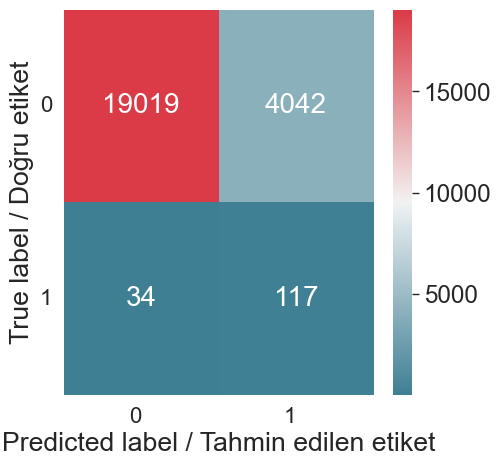

In [111]:
# Plot the confusion matrix for easier viewing
# Daha kolay görüntüleme için karışıklık matrisini çiz

# Plot Attributes
# Grafik Nitelikleri
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Seaborn Heatmap - passing confusion matrix
# Seaborn Isı Haritası - kafa karışıklığı matrisini geçme
heatmap = sns.heatmap(cm_gnb_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)

# Heatmap attributes
# Isı haritası özellikleri
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label / Doğru etiket')
plt.xlabel('Predicted label / Tahmin edilen etiket');

#### 7.3.2) Key Metrics
#### 7.3.2) Temel Metrikler

In [112]:
gnb_metrics = get_metrics(y_test,y_pred_gnb,y_prob_df_gnb[1])

Accuracy / Doğruluk: 82.44% 
Error / Hata : 17.56%

Classification Report / Sınıflandırma Raporu
              precision    recall  f1-score   support

           0     0.9982    0.8247    0.9032     23061
           1     0.0281    0.7748    0.0543       151

    accuracy                         0.8244     23212
   macro avg     0.5132    0.7998    0.4788     23212
weighted avg     0.9919    0.8244    0.8977     23212

AUC: 0.86


----------------------

## 8) Support Vector Machines
## 8) Vektör Makinelerini Destekleyin

### 8.1) Train the Model
### 8.1) Modeli Eğitin

In [113]:
svc = SVC(probability = True)

In [114]:
# Train the model
# Modeli eğit
svc.fit(x_train_scaled,y_resampled)

SVC(probability=True)

### 8.2) Predicting on Test Set
### 8.2) Test Setinde Öngörüde Bulunma

In [115]:
y_pred_svc = svc.predict(x_test_scaled)

In [116]:
y_pred_svc

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [117]:
# Predict probabilities using the "predict_proba" function
# "predict_proba" işlevini kullanarak olasılıkları tahmin edin
y_prob_svc = svc.predict_proba(x_test_scaled)

In [118]:
# Check the shape, there should be two columns, one for each class
# Şekli kontrol et, her sınıf için bir tane olmak üzere iki sütun olmalı
y_prob_svc.shape

(23212, 2)

In [119]:
# Create a DataFrame
# Bir DataFrame oluşturun
y_prob_df_svc = pd.DataFrame(y_prob_svc, index=y_test.index)

y_prob_df_svc.head(3)

,0,1
49952,0.7971,0.2029
42044,0.9530,0.0470
34880,0.9857,0.0143


### 8.3) Check Model Performance
### 8.3) Model Performansını Kontrol Edin

#### 8.3.1) Confusion Matrix
#### 8.3.1) Karışıklık Matrisi

In [120]:
# Get the Confusion Matrix
# Karışıklık Matrisini Alın
cm_svc = metrics.confusion_matrix(y_test, y_pred_svc, labels=labels)

# Put in DataFrame
# DataFrame'e koy
cm_svc_df = pd.DataFrame(cm_svc, index=labels, columns=labels)

# View the DataFrame
# DataFrame'i görüntüle
cm_svc_df

,0,1
0,20802,2259
1,39,112


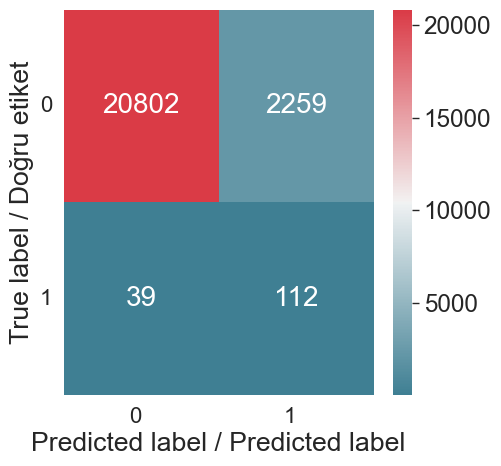

In [121]:
# Plot the confusion matrix for easier viewing
# Daha kolay görüntüleme için karışıklık matrisini çiz

# Plot Attributes
fig = plt.figure(figsize= (5,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)


# Seaborn Heatmap - passing confusion matrix
# Seaborn Isı Haritası - karışıklık matrisini geçirme
heatmap = sns.heatmap(cm_svc_df,annot=True,annot_kws={"size": 20}, fmt="d", cmap=cmap)


# Heatmap attributes
# Isı haritası özellikleri
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
plt.ylabel('True label / Doğru etiket')
plt.xlabel('Predicted label / Predicted label');

#### 7.3.2) Key Metrics
#### 7.3.2) Temel Metrikler

In [122]:
svc_metrics = get_metrics(y_test,y_pred_svc,y_prob_df_svc[1])

Accuracy / Doğruluk: 90.1% 
Error / Hata : 9.9%

Classification Report / Sınıflandırma Raporu
              precision    recall  f1-score   support

           0     0.9981    0.9020    0.9477     23061
           1     0.0472    0.7417    0.0888       151

    accuracy                         0.9010     23212
   macro avg     0.5227    0.8219    0.5182     23212
weighted avg     0.9919    0.9010    0.9421     23212

AUC: 0.89


----------------------

## 9) Voting Classifier
## 9) Oylama Sınıflandırıcı

### 9.1) Train the Model
### 9.1) Modeli Eğitin

In [123]:
# Instantiate the Algorithm
# Algoritmayı somutlaştırın
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=21)),
        ('rf', RandomForestClassifier(random_state=21)),
        ('svc', SVC(probability = True, random_state=21))
    ]
)

In [124]:
# Train the model
# Modeli eğit
voting_clf.fit(x_train_scaled,y_resampled)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=21)),
                             ('rf', RandomForestClassifier(random_state=21)),
                             ('svc', SVC(probability=True, random_state=21))])

In [125]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(x_test_scaled, y_test))

lr = 0.8599000516973979
rf = 0.983370670342926
svc = 0.9009994830260211


----------------------

## 9) Model Selection
## 9) Model Seçimi

In [126]:
# Create Dataframe for Performance Metrics of ALl Models
# TÜM Modellerin Performans Metrikleri için Veri Çerçevesi Oluşturun

metric_labels = ("Accuracy (%)", "Precision","Recall", "F1 Score","AUC")
class_models = ("Logistic Regression","Random Forest","Naive Bayes", "Support Vector Machines")
metrics = (logreg_metrics,rf_metrics, gnb_metrics, svc_metrics)

df_modelperf = pd.DataFrame(index = metric_labels)

In [127]:
m = 0
for i in class_models:
    df_modelperf[i] = metrics[m]
    m += 1
    if m > len(metrics) - 1:
        break

In [128]:
df_modelperf

,Logistic Regression,Random Forest,Naive Bayes,Support Vector Machines
Accuracy (%),85.9900,98.2800,82.4400,90.1000
Precision,0.0331,0.1022,0.0281,0.0472
Recall,0.7285,0.2119,0.7748,0.7417
F1 Score,0.0634,0.1379,0.0543,0.0888
AUC,0.8747,0.8276,0.8641,0.8893
